# Ensemble Learning Assessment

### Grupo 1 (Dataset G01A): Álvaro Ezquerro, María Calvo de Mora y Celia Quiles

# Práctica:

El objetivo de esta práctica es realizar un trabajo de Machine Learning en el que, a partir de datos relacionados con la irradiación solar y las utilizaciones solares fotovoltaicas, datos que serán previamente explorados y descritos, estimaremos las utilizaciones horarias de un día.

Esto se realizará utilizando técnicas de ensamblado, así como se compararán los resultados con los que obtendríamos con alguna técnica más directa.

#### Importamos librerías:

In [1]:
import warnings

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, SplineTransformer
from sklearn.utils import resample  
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.ensemble import VotingRegressor, StackingRegressor


# others
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT
from mltools.regression_tools import LinearRegressor


#### Cargamos datos y realizamos los ajustes necesarios:

In [2]:
df_orig_Irrad = pd.read_csv("./data/G01A_DATOS_IRRAD.csv")
df_orig_Util = pd.read_csv("./data/G01A_DATOS_UTIL.csv")

# parseamos la fecha (cadena) para que sea un datetime con formato yyyy/mm/dd
df_orig_Irrad['FECHA'] = pd.to_datetime(df_orig_Irrad['FECHA'], format='%Y-%m-%d')
df_orig_Util['FECHA'] = pd.to_datetime(df_orig_Util['FECHA'], format='%Y-%m-%d')

## 1) Análisis Exploratorio de los Datos:

El Análisis Exploratorio de Datos (EDA) es una fase crucial en cualquier proyecto de ciencia de datos o aprendizaje automático. Consiste en explorar, entender y visualizar los datos disponibles antes de aplicar cualquier modelo predictivo. En el contexto de la predicción de utilizaciones solares fotovoltaicas, el EDA desempeña un papel fundamental debido a la complejidad inherente de los datos solares y la necesidad de comprender completamente su comportamiento y relaciones.

### En primer lugar, entendamos **qué variables tenemos y qué significan**.

En concreto, en este trabajo contamos con 2 datasets, uno relatvo a las irradiaciones solares, y otro sobre las utilizaciones solares fotovoltaicas.

La irradiación solar se refiere a la cantidad de radiación solar que llega a una superficie determinada en un período de tiempo específico, mientras que la utilización solar fotovoltaica se refiere a la cantidad de energía eléctrica generada por un sistema fotovoltaico en ese mismo período de tiempo.

**Veamos primero el dataset de las irradiaciones:**

In [3]:
df_orig_Irrad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FECHA     2192 non-null   datetime64[ns]
 1   IRRADH00  2192 non-null   float64       
 2   IRRADH03  2192 non-null   float64       
 3   IRRADH06  2192 non-null   float64       
 4   IRRADH09  2192 non-null   float64       
 5   IRRADH12  2192 non-null   float64       
 6   IRRADH15  2192 non-null   float64       
 7   IRRADH18  2192 non-null   float64       
 8   IRRADH21  2192 non-null   float64       
 9   ANNO      2192 non-null   int64         
 10  MES       2192 non-null   int64         
 11  DIA       2192 non-null   int64         
 12  DIASEM    2192 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 222.8 KB


Este dataset cuenta con 12 variables.

- Por un lado tenemos las 5 variables relacionadas con la fecha del registro en cuestión: `FECHA` (día, mes y año del registro), `ANNO`, `MES`, `DIA` y `DIASEM`. Estas variables nos permitirán establecer una especie de relación temporal en los registros, sin llegar a usar ningún métodod de forecasting ni de series temporales.
Todas ellas son números enteros, salvo `FECHA` que es de tipo datetime.

(Tenemos datos diarios desde enero del 2015 hasta diciembre del 2020).

- Las 8 columnas restantes, son las `columnas relativas a las irradiaciones solares` del día en cuestión. Tenemos valores cada 3 horas (00, 03, 06...). Esto se debe a que la irradiación solar del tramo horario h es la **irradiación acumulada** de las horas h, h+1 y h+2.


In [4]:
print('Number of NAs in dataframe:',df_orig_Irrad.isnull().values.sum())

Number of NAs in dataframe: 0


No existen valores nulos en el dataset.

**Seguimos con el dataset de las utilizaciones:**

In [5]:
df_orig_Util.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   FECHA    2192 non-null   datetime64[ns]
 1   UTILH00  2192 non-null   float64       
 2   UTILH03  2192 non-null   float64       
 3   UTILH06  2192 non-null   float64       
 4   UTILH09  2192 non-null   float64       
 5   UTILH12  2192 non-null   float64       
 6   UTILH15  2192 non-null   float64       
 7   UTILH18  2192 non-null   float64       
 8   UTILH21  2192 non-null   float64       
 9   ANNO     2192 non-null   int64         
 10  MES      2192 non-null   int64         
 11  DIA      2192 non-null   int64         
 12  DIASEM   2192 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 222.8 KB


Este dataset vuelve a contar con 12 variables, muy similares a las anteriores.

- Por un lado tenemos las 5 variables relacionadas con la fecha del registro en cuestión: `FECHA` (día, mes y año del registro), `ANNO`, `MES`, `DIA` y `DIASEM`. Estas variables nos permitirán establecer una especie de relación temporal en los registros, sin llegar a usar ningún métodod de forecasting ni de series temporales.
Todas ellas son números enteros, salvo `FECHA` que es de tipo datetime.

(Tenemos datos diarios desde enero del 2015 hasta diciembre del 2020).

- Las 8 columnas restantes, son las `columnas relativas a las utilizaciones solares fotovoltaicas` del día en cuestión. Volvemos a tener valores cada 3 horas (00, 03, 06...). Esto se debe a que la utilización del tramo horario h es la **utilización media** de las horas h, h+1 y h+2.

In [6]:
print('Number of NAs in dataframe:',df_orig_Util.isnull().values.sum())

Number of NAs in dataframe: 0


Este dataset tampoco tiene valores ausentes.

### Distribución variables:

### 1) Dataset Irradiaciones:

A continuación veamos qué comportamiento tienen cada una de las irradiaciones y utilizaciones. Para eso, vamos a representar su evolución temporal con gráficos de líneas.

Para comenzar, represento todas las irradiaciones solares en un mismo gráfico, diferenciando con el color entre los distintos tramos horarios.

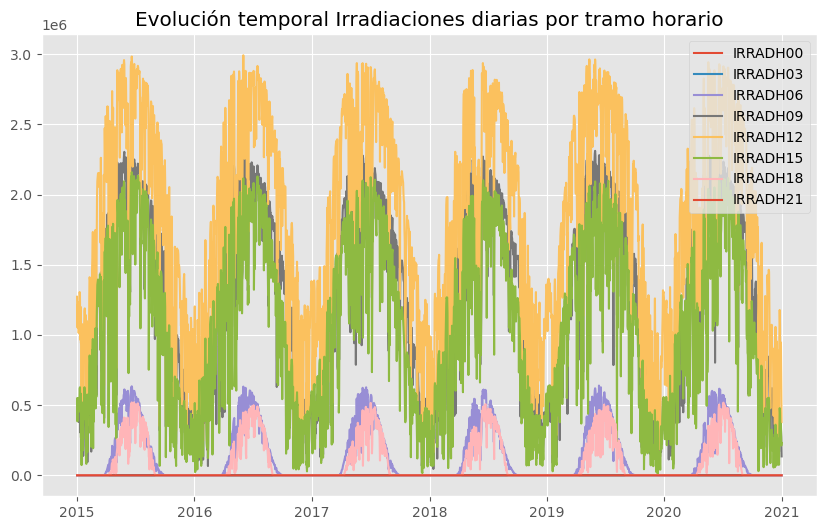

In [7]:
def graficar_serie_original(df, columns, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    for column in columns:
        plt.plot(df['FECHA'], df[column], label=column)
    plt.grid(True)
    plt.legend()
    plt.show()

# Lista de columnas que quieres graficar
columnas = ['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18', 'IRRADH21']

# Llamar a la función con la lista de columnas
graficar_serie_original(df_orig_Irrad, columnas, "Evolución temporal Irradiaciones diarias por tramo horario")


En este gráfico de irradación solar, es decir, cuánto sol hay a lo largo de cada día y hora, podemos ver los siguientes resultados que podríamos preveer:

- Cuando se registran los **valores más superiores independientemente del mes de año, es durante el tramo horario de las 12** (irradiación acumulada a las 12, 13 y 14 horas, es decir, el mediodía.

- A este tramo **le siguen el de las 9am (9, 10 y 11 horas) y el de las 15** (15, 16 y 17h). 

Todo esto ocurre en todas las épocas del año, pues son horas del día que, **independientemente de si el día es más largo o más corto, a estas horas es de día igualmente**, y debido a tener el sol al norte, con ninguna o ligera inclinación, la potencia de la irradiación es mayor. No obstante, ambas 3 series sí **tienen un patrón estacional anual también.** En invierno, por ejemplo, al haber menos días soleados, la irradiación solar es mucho más baja que en los meses de verano, donde alcanzamos los picos.

- Los **2 siguientes tramos son los correspondientes a las 06 (06, 07 y 08 horas, am) y el de las 18 (18, 19 y 20 horas)**. Estos dos tramos, además de que la irradiación recibida es mucho menor pues, aunque aún haga luz, debido a la inclinación la potencia de la **irradiación es menor**, además, solo registran irradiación en los meses de verano, final de primavera y principios de otoño. Esto se debe a que **en invierno, no hay luz a estas horas del día.**

- Finalmente, **en los tramos de las 21 horas, 00h y 03h, al ser de noche durante todos los meses del año, la irradiación siempre es 0.**

Puedo también realizar una descomposición de las series temporales con el método `seasonal_decompose` de statsmodels y extraer la componente seasonal de cada tramo para verlo de manera más clara.

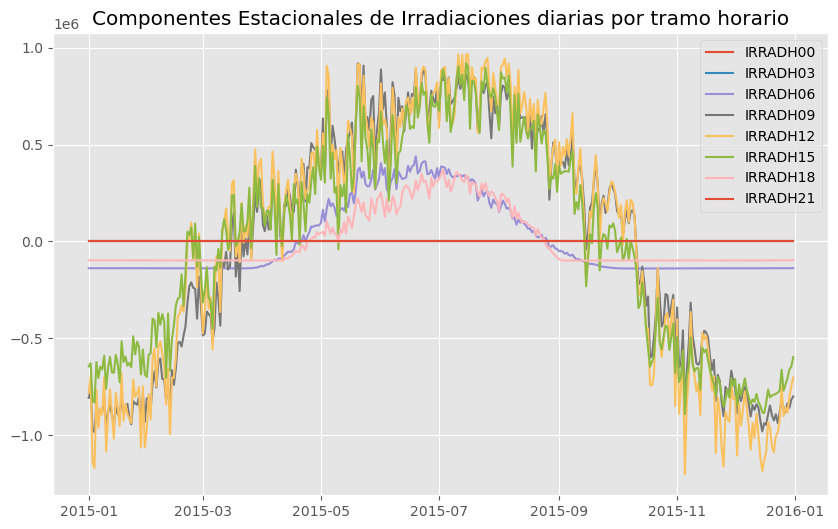

In [8]:
def graficar_serie_estacional(df, columns, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    for column in columns:
        res = sm.tsa.seasonal_decompose(df[column], model='additive', period=365)  # 24 horas en un día
        seasonal_component = res.seasonal[:365]
        plt.plot(df.index[:365], seasonal_component, label=column)
    plt.grid(True)
    plt.legend()
    plt.show()

# Lista de columnas que quieres graficar
columnas = ['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18', 'IRRADH21']

df = df_orig_Irrad.set_index('FECHA')
# Llamar a la función con la lista de columnas
graficar_serie_estacional(df, columnas, "Componentes Estacionales de Irradiaciones diarias por tramo horario")


- Aquí se aprecia cómo los valores para los tramos de la noche son planos. 
- Para los tramos de las 06h y 18h solo hay irradiación (ligera irradiación) desde mayo hasta septiembre.
- El resto de tramos horarios registran más volatilidad durante el año, alcanzando los valores máximos en agosto (y en verano en general), mientras que los valores mínimos son en diciembre, justamente cuando los días son más cortos.

Para terminar el análisis de las irradiaciones, voy a extraer en esta ocasión la tendencia / Nivel de la serie, que nos va a permitir extraer 2 conclusiones: 1) en torno a qué valores se mueve cada tramo y 2) si ha habido una tendencia clara en algún tramos durante estos años.

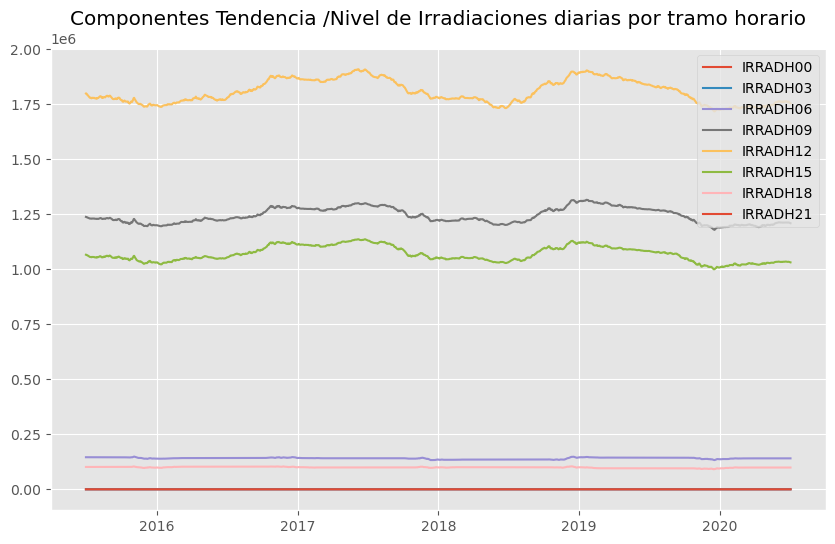

In [9]:
def graficar_serie_trend(df, columns, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    for column in columns:
        res = sm.tsa.seasonal_decompose(df[column], model='additive', period=365)  # 24 horas en un día
        trend_component = res.trend
        plt.plot(df.index, trend_component, label=column)
    plt.grid(True)
    plt.legend()
    plt.show()

# Lista de columnas que quieres graficar
columnas = ['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18', 'IRRADH21']

df = df_orig_Irrad.set_index('FECHA')
# Llamar a la función con la lista de columnas
graficar_serie_trend(df, columnas, "Componentes Tendencia /Nivel de Irradiaciones diarias por tramo horario")


Ninguno de los tramos ha sufrido una tendencia clara ni positiva ni negativa, como es normal. Es decir, la irradiación durante los años ha sido constante en cada uno de los diferentes tramos horarios.

Pero sí que nos sirve el gráfico para ver de manera más clara la diferencia en los valoes promedios de cada tramo: cuando el valor es más elevado es en el tramo del mediodía, el de las 12h (12h + 13h + 14h), seguido del de las 9h y 15h, como ya adelantábamos anteriormente.

En último lugar, represento los boxplots de cada tramo horario, para identificar valores outliers por tramo horario.

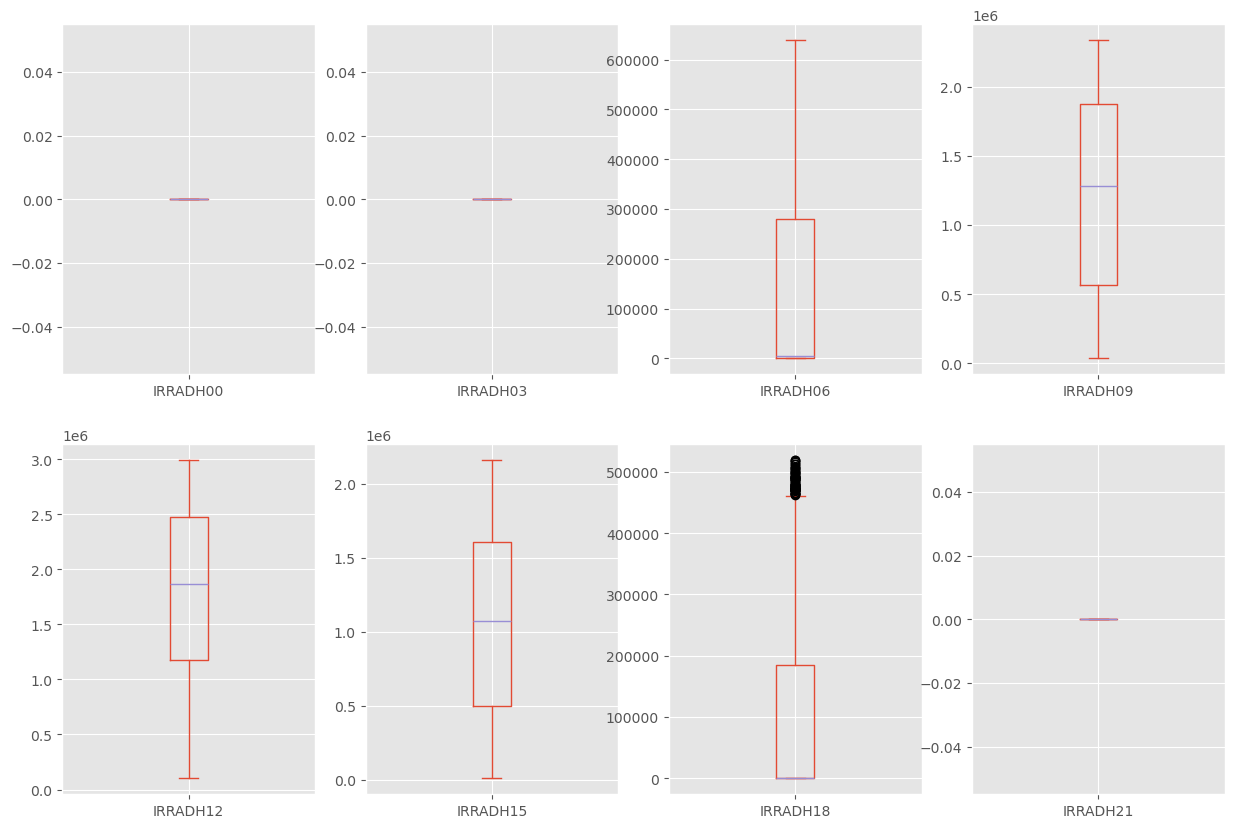

In [10]:
ax = df_orig_Irrad.loc[:, ['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18', 'IRRADH21']].plot(
    kind='box', subplots=True, layout=(2,4),figsize=(15, 10), sharex=False, sharey=False)  


Los tramos de las 00h, 03h y 21h al ser una serie de 0s, no tienen ninguna variabilidad.

Los tramos centrales del día, como pese a tener cierta variabilidad a lo largo del año en función de si es invierno, verano, etc. Tampoco tienen valores outliuers pues son tramos horarios donde todos los días hay cieta irradiación, sea más o menos.

No obstante, es en el tramos de las 18h en el que hay bastantes outliers debido a poseer valores elevados de irradiación. Estos serán justamente los valores registrados en junio-julio que es cuando esta serie registra anualmente sus valores máximos.

### 2) Dataset Utilizaciones:

Para comenzar con este dataset, represento todas las utilizaciones solares fotovoltaicas en un mismo gráfico, diferenciando con el color entre los distintos tramos horarios.

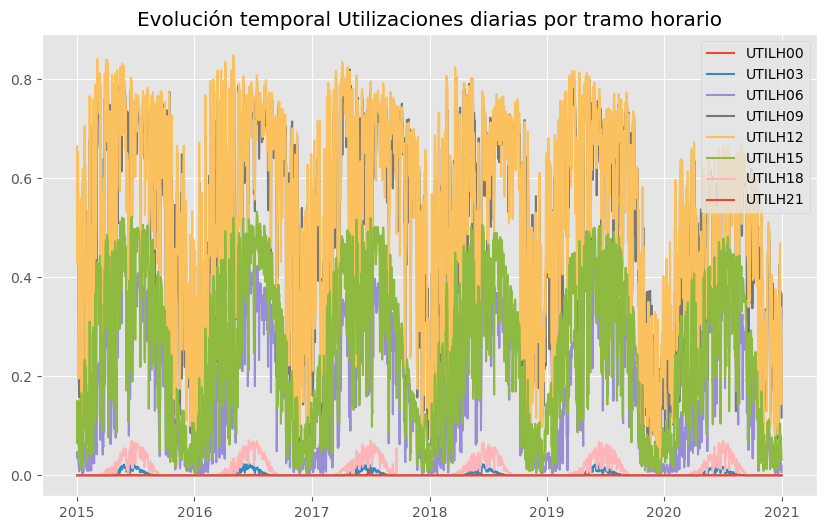

In [11]:
columnas = ['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 'UTILH12',
       'UTILH15', 'UTILH18', 'UTILH21']

graficar_serie_original(df_orig_Util, columnas, "Evolución temporal Utilizaciones diarias por tramo horario")


En este gráfico de utilización solar, es decir, qué cantidad de energía eléctrica se puede generar por un sistema fotovoltaico en un período de tiempo, lo cual dependerá principalmente de cuánta irradiación solar haya a lo largo de cada día y hora. Estudiemos los patrones de este dataset:

- Cuando se registran los **valores más superiores independientemente del mes de año, es durante el tramo horario de las 12** (irradiación acumulada a las 12, 13 y 14 horas, es decir, el mediodía. Muy seguido del tramos de las 9am (9h, 10h y 11h).

- A este tramo **le siguen el de las 15 (15, 16 y 17h) y el de las 06am (06h, 07h y 08h). 

Todo esto ocurre en todas las épocas del año, pues son horas del día que, **independientemente de si el día es más largo o más corto, a estas horas es de día igualmente**, y debido a tener el sol al norte, con ninguna o ligera inclinación, la potencia de la irradiación es mayor y la utilización aumenta en consecuencia. No obstante, ambas 4 series sí **tienen un patrón estacional anual también.** En invierno, por ejemplo, al haber menos días soleados, la utilización solar es mucho más baja que en los meses de verano, donde alcanzamos los picos.

**Destaco las diferencias respecto a los patrones de irradiación estudiados antes**, ahora a las 09h los valores son muy superiores a las 15h, mientras que antes eran valores similares. Esto se debe a que, las irradiaciones se calculan como un acumulado de las 3h, mientras que las utilizaciones son una media !!!!!



- Los **2 siguientes tramos son los correspondientes a las 03 (03, 04 y 05 horas, am) y el de las 18 (18, 19 y 20 horas)**. Estos dos tramos solo registran utilizaciones en los meses de verano, final de primavera y principios de otoño. Esto se debe a que **en invierno, no hay luz a estas horas del día.**

- Finalmente, **en los tramos de las 21 horas y 00h, al ser de noche durante todos los meses del año, la irradiación y la utilización siempre es 0.**

Puedo también realizar una descomposición de las series temporales con el método `seasonal_decompose` de statsmodels y extraer la componente seasonal de cada tramo para verlo de manera más clara.

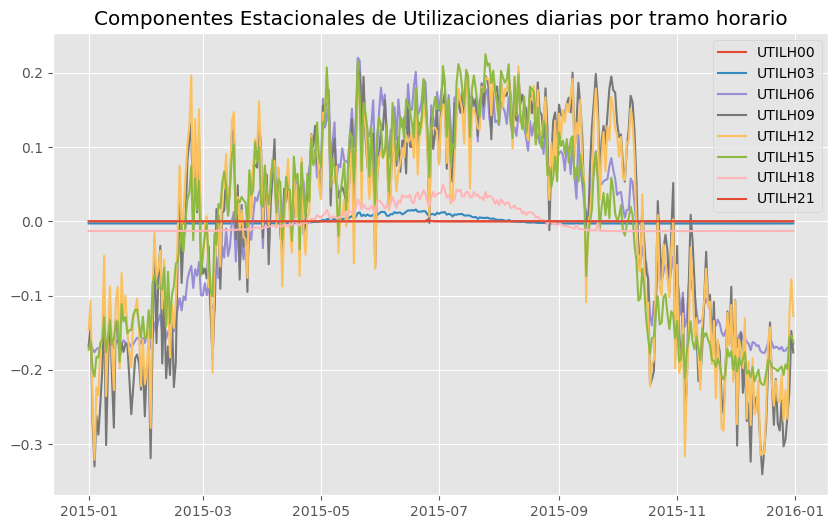

In [12]:
# Lista de columnas que quieres graficar
columnas = ['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 'UTILH12',
       'UTILH15', 'UTILH18', 'UTILH21']

df = df_orig_Util.set_index('FECHA')
# Llamar a la función con la lista de columnas
graficar_serie_estacional(df, columnas, "Componentes Estacionales de Utilizaciones diarias por tramo horario")


- Aquí se aprecia cómo los valores para los tramos de la noche son planos. 
- Para los tramos de las 03h y 18h solo hay irradiación (ligera irradiación) desde mayo hasta agosto/septiembre.
- El resto de tramos horarios registran más volatilidad durante el año, alcanzando los valores máximos en agosto (y en verano en general), mientras que los valores mínimos son en diciembre, justamente cuando los días son más cortos.

Para terminar el análisis de las irradiaciones, voy a extraer en esta ocasión la tendencia / Nivel de la serie, que nos va a permitir extraer 2 conclusiones: 1) en torno a qué valores se mueve cada tramo y 2) si ha habido una tendencia clara en algún tramos durante estos años.

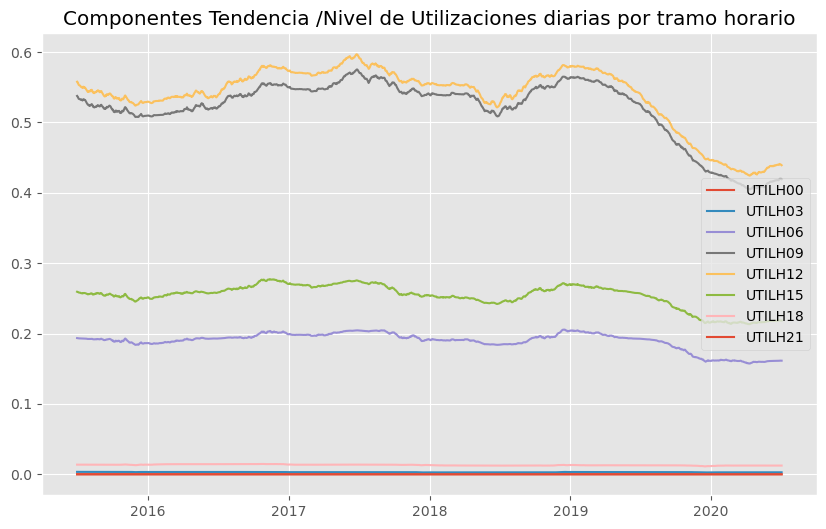

In [13]:
# Lista de columnas que quieres graficar
columnas = ['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 'UTILH12',
       'UTILH15', 'UTILH18', 'UTILH21']

df = df_orig_Util.set_index('FECHA')
# Llamar a la función con la lista de columnas
graficar_serie_trend(df, columnas, "Componentes Tendencia /Nivel de Utilizaciones diarias por tramo horario")


- Tal y como anticipaba antes, los valores máximos se alcanzan a las 12h, muy seguido de las 9h.
- A ellos les sigue el tramo de las 15h y el de las 06h.
- Después tenemos cierto valor de utilización a las 18h y algo, casi nada a las 03. Mientras que los valores a las 21 y a las 00h es siempre igual a 0.

En último lugar, represento los boxplots de cada tramo horario, para identificar valores outliers por tramo horario.

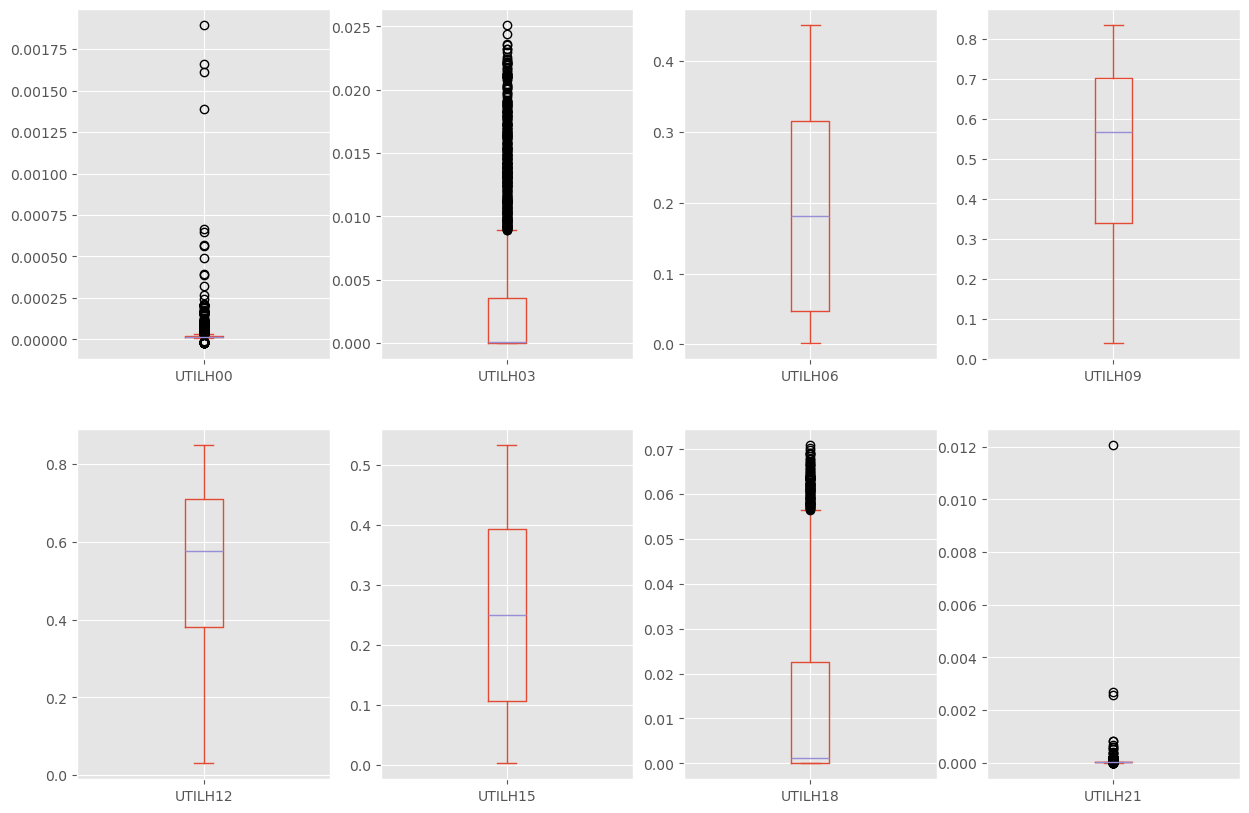

In [14]:
ax = df_orig_Util.loc[:, ['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 'UTILH12',
       'UTILH15', 'UTILH18', 'UTILH21']].plot(
    kind='box', subplots=True, layout=(2,4),figsize=(15, 10), sharex=False, sharey=False)  


A diferencia del dataset de Irradiaciones, aquí existen más valores atípicos.

- Por un lado, tenemos atípicos a las 21h y 00h, esto se debe a que pese a que la serie es igual a 0 en la mayoría de los casos, también hay ciertas fechas con valores distintos a 0, lo que hace que se conviertan en outliers.

- Por otra parte, en los datasets de las 03h y las 18h vuelve a ocurrir como pasaba en el caso de las irradiaciones. Hay bastantes outliers debido a poseer valores elevados de utilización. Estos serán justamente los valores registrados en junio-julio que es cuando esta serie registra anualmente sus valores máximos.

Veamos el caso de las 00 y 21, para identificar los outliers:

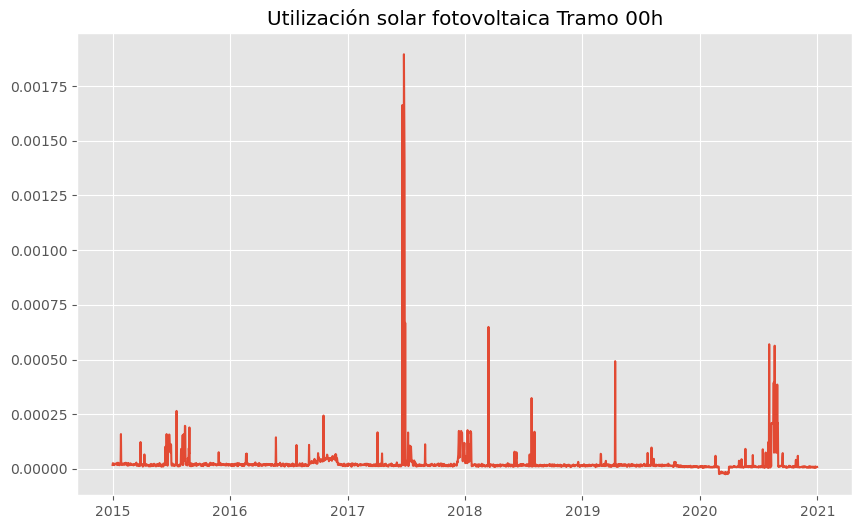

In [15]:
def graficar_serie_original(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(df['FECHA'], df[column], label=f'Evolución temporal:')
    plt.grid(True)
    plt.show()
    
graficar_serie_original(df_orig_Util, 'UTILH00', "Utilización solar fotovoltaica Tramo 00h")

La serie presenta casi todo 0s, salvo ciertas excepciones, entre las que destacamos 2 fechas de verano del 2017.

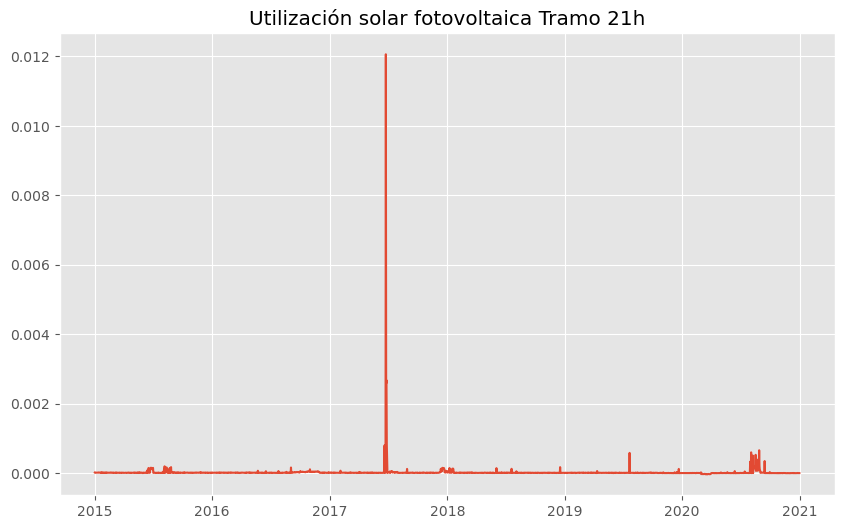

In [16]:
graficar_serie_original(df_orig_Util, 'UTILH21', "Utilización solar fotovoltaica Tramo 21h")

En esta serie vuelve a ocurrir lo de verano de 2017.

### Relaciones entre variables

Para terminar con el EDA, procedemos a representar la relación entre variables con una matriz de correlaciones para cada dataset.

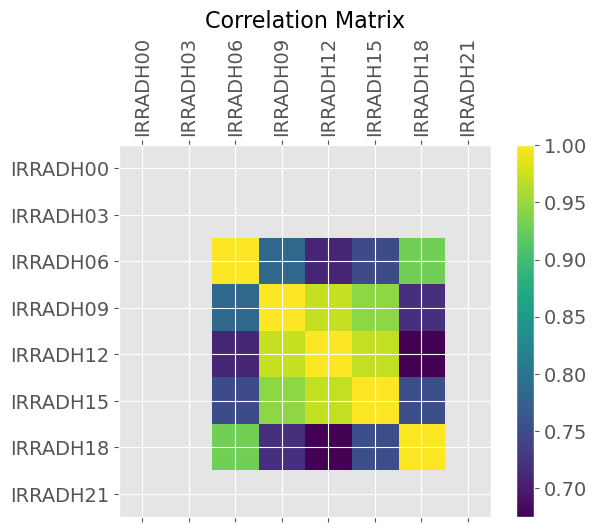

In [17]:
#Correlation plot of numeric variables
f = plt.figure()
plt.matshow(df_orig_Irrad.select_dtypes(include=['float64']).corr(), fignum=f.number)
plt.xticks(range(df_orig_Irrad.select_dtypes(include=['float64']).shape[1]), df_orig_Irrad.select_dtypes(include=['float64']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_orig_Irrad.select_dtypes(include=['float64']).shape[1]), df_orig_Irrad.select_dtypes(include=['float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


En este primer gráfico de correlaciones, tenemos valores constantes iguales a 0 en las columnas 'IRRADH00', 'IRRADH03' e 'IRRADH21', por lo que en consecuencia, sus columnas y filas son blancas.

En cuanto al resto, se aprecia una correlación muy alta entre las irradiaciones de las 12h y las 09h, correlacion cercana a 1. A esta, le sigue la correlación entre las irradiaciones de las 15h y las 09h, así como la de las 18h y las 06h, ambas correlaciones tienen valores superiores a 0.9.

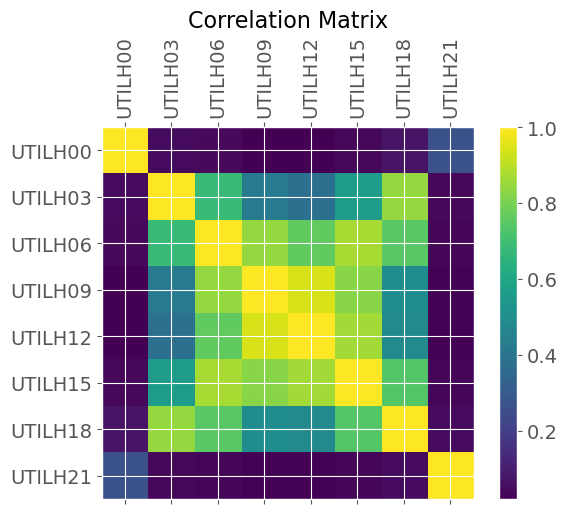

In [18]:
#Correlation plot of numeric variables
f = plt.figure()
plt.matshow(df_orig_Util.select_dtypes(include=['float64']).corr(), fignum=f.number)
plt.xticks(range(df_orig_Util.select_dtypes(include=['float64']).shape[1]), df_orig_Util.select_dtypes(include=['float64']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_orig_Util.select_dtypes(include=['float64']).shape[1]), df_orig_Util.select_dtypes(include=['float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


En este segundo gráfico de correlaciones, de nuevo la correlación más elevada es aquella que se da entre las utilizaciones de las 09h y las 12h, seguida muy de cerca de la correlación entre las 06h y 15h, junto con la de las 03h y 18h y la de las 12h y 15h.

Todas ellas son superiores a 0.85, y se relacionan bastante con lo mencionado anteriormente al estudiar los patrones estacionales y de tendencia de cada uno de los tramos horarios.

## 2) Preparación de los datos y Feature Engineering:

Previamente a llevar a cabo cualquier tipo de modelo, se necesita definir cuál va a ser la columna que pretendemos predecir (tarea de regresión), así como identificar qué variables pueden ser útiles para esta tarea, bien sean columnas ya incluidas en alguno de los datasets, o columnas a las que les hagamos los ajustes necesarios.

#### Target de nuestro problema:
Nuestro objetivo es predecir cuál va a ser la utilización solar fotovoltaica para un tramos horario determinado, un dia, mes y año concreto. No obstante, nosotros ahoramismo tenemos una columna para tramos horario de utilización.

Si dejáramos aís el datatset, necesitaríamos entrenar los modelos 8 veces distintas, asumiendo cada vez que el target es un tramo horario de utilización concreto (iríamos cambiando la columna considerada target del problema).

Para no tener que hacer esto, y poder directamente entrenar el modelo de manera  que pueda predecir la utilización de cualquier tramo horario, vamos a recoger en una columna `UTILH`todas las utilizaciones (en lugar de tener 1 registro por día, ahora tendremos 8, uno para cada tramo horario).

#### Variables explicativas:
Ahora bien, para no perder la capacidad explicativa que tienen los valores de los otros tramos horarios sobre nuestro target (como se demostraba en la matriz de autocorrelación, la utilización de las 9h por ejemplo, es casi la utilización de las 12h), añadimos las siguientes columnas como variables explicativas:

- 'UTILH_TramoAnterior', será la utilización registrada ese mismo día 3 horas antes
- 'UTILH_TramoAnterior_x2', será la utilización registrada ese mismo día 6 horas antes (2 tramos horarios antes)
- 'UTILH_TramoAnterior_x3', será la utilización registrada ese mismo día 9 horas antes (3 tramos horarios antes)
- --------

- 'UTILH_TramoPosterior', será la utilización registrada el día anterior horas después
- 'UTILH_TramoPosterior_x2', será la utilización registrada el día anterior 6 horas después (2 tramos horarios después)
- 'UTILH_TramoPosterior_x3', será la utilización registrada el día anterior 9 horas después (3 tramos horarios después)

- --------
- 'UTILH_DiaAnterior', será la utilización registrada a esa misma hora el día anterior
- 'UTILH_DiaAnterior_x2', será la utilización registrada a esa misma hora 2 días anteriores
- 'UTILH_AñoAnterior', será la utilización registrada a esa misma hora el mismo día un año antes
- --------
- 'IRRAD_misma_hora', será la irradiación registrada ese mismo día a esa misma hora
- --------

- 'IRRADH_TramoAnterior', será la irradiación registrada ese mismo día 3 horas antes
- 'IRRADH_TramoAnterior_x2', será la irradiación registrada ese mismo día 6 horas antes
- 'IRRADH_TramoAnterior_x3', será la irradiación registrada ese mismo día 9 horas antes
- --------
- 'IRRADH_TramoPosterior', será la irradiación registrada el día anterior 3 horas después
- 'IRRADH_TramoPosterior_x2', será la irradiación registrada el día anterior 6 horas después
- 'IRRADH_TramoPosterior_x3', será la irradiación registrada el día anterior 9 horas después

- --------
- 'DIA', 'MES', 'DIAMES' y 'TramoHorario' para complementar en lo relativo a la fecha-hora del registro


Cabe destacar que todos los datos se cogen sobre el mismo día o sobre días pasados, pues en la práctica no tendremos los datos de mañana.

### Ajustes:

En primer lugar, lo que hacemos es unir ambos datasets con el objetivo de tenerlos ya todos unidos por fecha: para un día concreto, tendremos todas las irradiaciones y utilizaciones.

In [19]:
df = pd.merge(df_orig_Irrad, df_orig_Util, on=['FECHA','ANNO', 'DIA', 'MES', 'DIASEM'], how='inner')
df.head()

FECHA  IRRADH00  IRRADH03  IRRADH06   IRRADH09   IRRADH12   IRRADH15  \
0 2015-01-01       0.0       0.0       0.0  523837.12  1271952.9  546891.60   
1 2015-01-02       0.0       0.0       0.0  415609.53  1053375.0  384609.90   
2 2015-01-03       0.0       0.0       0.0  492834.47  1216754.2  524360.25   
3 2015-01-04       0.0       0.0       0.0  484310.66  1197360.9  540491.40   
4 2015-01-05       0.0       0.0       0.0  496480.66  1234322.1  550704.60   

   IRRADH18  IRRADH21  ANNO  ...  DIA  DIASEM   UTILH00   UTILH03   UTILH06  \
0       0.0       0.0  2015  ...    1       3  0.000018  0.000024  0.046463   
1       0.0       0.0  2015  ...    2       4  0.000026  0.000017  0.034464   
2       0.0       0.0  2015  ...    3       5  0.000024  0.000019  0.043842   
3       0.0       0.0  2015  ...    4       6  0.000024  0.000021  0.043075   
4       0.0       0.0  2015  ...    5       0  0.000018  0.000020  0.028095   

    UTILH09   UTILH12   UTILH15   UTILH18   UTILH21  
0  0.596802  0.665174  0.149360  0.000026  0.000023  
1  0.479592  0.428163  0.064205  0.000020  0.000016  
2  0.581361  0.653290  0.148808  0.000019  0.000020  
3  0.575162  0.649301  0.149390  0.000017  0.000020  
4  0.411633  0.538281  0.136266  0.000021  0.000021  

[5 rows x 21 columns]

Una vez ya tenemos un único dataset, realizamos el cambio de target y la adición de las variables explicativas que hemos mencionado unos párrafos antes.

In [20]:

df['FECHA'] = pd.to_datetime(df['FECHA'])

util_columns = [col for col in df.columns if col.startswith('UTILH')]

irrad_columns = [col for col in df.columns if col.startswith('IRRADH')]

rows = []


for date, group in df.groupby('FECHA'):
    
    for i, util_hour in enumerate(util_columns):
        
        hour = int(util_hour[5:])
        
        row = {
            'FECHA': date,
            'ANNO': group['ANNO'].iloc[0],
            'MES': group['MES'].iloc[0],
            'DIA': group['DIA'].iloc[0],
            'DIASEM': group['DIASEM'].iloc[0],
            'Tramo_Horario': hour,  
            
            'UTILH': group[util_hour].iloc[0],
            'UTILH_TramoAnterior': group[util_columns[i - 1]].iloc[0] if i > 0 else 0,
            'UTILH_TramoAnterior_x2': group[util_columns[i - 2]].iloc[0] if i > 1 else 0,
            'UTILH_TramoAnterior_x3': group[util_columns[i - 3]].iloc[0] if i > 2 else 0,
            
            'IRRAD_misma_hora': group[irrad_columns[i]].iloc[0],
            'IRRADH_TramoAnterior': group[irrad_columns[i - 1]].iloc[0] if i > 0 else 0,
            'IRRADH_TramoAnterior_x2': group[irrad_columns[i - 2]].iloc[0] if i > 1 else 0,  
            'IRRADH_TramoAnterior_x3': group[irrad_columns[i - 3]].iloc[0] if i > 2 else 0
            
        }
        rows.append(row)


result_df = pd.DataFrame(rows)
result_df['UTILH_DiaAnterior'] = result_df['UTILH'].shift(8).fillna(0)
result_df['UTILH_DiaAnterior_x2'] = result_df['UTILH'].shift(16).fillna(0)
result_df['UTILH_AñoAnterior'] = result_df['UTILH'].shift(8*365).fillna(0)
result_df['IRRADLH_AñoAnterior'] = result_df['IRRAD_misma_hora'].shift(8*365).fillna(0)
result_df['UTILH_TramoPosterior']= result_df['UTILH'].shift(7).fillna(0)
result_df['UTILH_TramoPosterior_x2']= result_df['UTILH'].shift(6).fillna(0)
result_df['UTILH_TramoPosterior_x3']= result_df['UTILH'].shift(5).fillna(0)
result_df['IRRADH_TramoPosterior']= result_df['IRRAD_misma_hora'].shift(7).fillna(0)
result_df['IRRADH_TramoPosterior_x2']= result_df['IRRAD_misma_hora'].shift(6).fillna(0)
result_df['IRRADH_TramoPosterior_x3']= result_df['IRRAD_misma_hora'].shift(5).fillna(0)

result_df = result_df[['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'Tramo_Horario', 'UTILH', 
                       'UTILH_DiaAnterior','UTILH_DiaAnterior_x2', 'UTILH_AñoAnterior',
                       'UTILH_TramoAnterior', 'UTILH_TramoPosterior', 
                       'UTILH_TramoAnterior_x2', 'UTILH_TramoPosterior_x2', 
                       'UTILH_TramoAnterior_x3', 'UTILH_TramoPosterior_x3','IRRAD_misma_hora', 'IRRADLH_AñoAnterior',
                       'IRRADH_TramoAnterior', 'IRRADH_TramoPosterior',
                      'IRRADH_TramoAnterior_x2', 'IRRADH_TramoPosterior_x2',
                      'IRRADH_TramoAnterior_x3', 'IRRADH_TramoPosterior_x3']]


### Train vs Test split

Ya con las nuevas columnas generadas, dividimos entre conjunto de train y conjunto de test. Como no vamos a actuar como un modelo de forecasting, esta división será de carácter aleatoria (no mantenemos estructura temporal).

**Importante:** Vamos a realizar una primera división 90-10 (10% que no se usará hasta el final, para verificar al 100% la capacidad generativa del modelo final que escojamos).

Ahora ya sí, de este 90%, obtenemos un train y test (80 y 20%, respectivamente).

In [21]:
# Define input and output matrices
INPUTS = ['ANNO', 'MES', 'DIA', 'DIASEM', 'Tramo_Horario', 'UTILH_DiaAnterior','UTILH_DiaAnterior_x2',
          'UTILH_AñoAnterior',
                       'UTILH_TramoAnterior', 'UTILH_TramoPosterior', 'UTILH_TramoAnterior_x2', 
                       'UTILH_TramoPosterior_x2', 'UTILH_TramoAnterior_x3', 'UTILH_TramoPosterior_x3',
          'IRRAD_misma_hora', 'IRRADLH_AñoAnterior',
                       'IRRADH_TramoAnterior', 'IRRADH_TramoPosterior',
                      'IRRADH_TramoAnterior_x2', 'IRRADH_TramoPosterior_x2', 'IRRADH_TramoAnterior_x3', 'IRRADH_TramoPosterior_x3']

OUTPUT = 'UTILH'

X = result_df[INPUTS] 
y = result_df[OUTPUT]

# Split 1
X_0, X_test_final, y_0, y_test_final = train_test_split(X, y,
                                                    test_size=0.1,   
                                                    random_state=0)

# Split 2
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0,
                                                    test_size=0.2,   
                                                    random_state=0)
## Create dataset to store model predictions
dfTR_eval = X_train.copy() 
dfTR_eval['Y'] = y_train 
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

## 3) Modelos de Regresión:

Para realizar el problema de regresión que se nos ha planteado, usaremos tanto modelos de ensamblado, como modelos más clásicos.

En concreto, estos serán los modelos que van a ser entrenados (todos ellos tuneando sus hiperparámetros y obteniendo métricas de error para compararlos posteriormente):

3.1) Regresión lineal

3.2) Árbol de regresión simple

3.3) Bagged Tree

3.4) Random Forest

3.5) AdaBoost

3.6) Gradient Boosting

### 3.1) Regresión Lineal:

Antes de entrar en los modelos de ensambado, vamos a entrenar un modelo simple e interpretable como es una regresión lineal. Este modelo nos servirá como `baseline`, y también nos aportará información sobre la importancia de las variables gracias a los coeficientes estimados.

In [22]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS)
])

# Definir el pipeline
pipe = Pipeline(steps=[
    ('Prep', preprocessor),  
    ('LinReg', LinearRegressor(fit_intercept=True))
])


nFolds = 3
param = {}  
LR_fit = GridSearchCV(
    estimator=pipe, 
    param_grid=param, 
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error',
    cv=nFolds  
)

# Ajustar el modelo
LR_fit.fit(X_train[INPUTS], y_train) 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'Tramo_Horario',
                                                                          'UTILH_DiaAnterior',
                                                                          'UTILH_DiaAnterior_x2',
                                                                          'UTILH_AñoAnterior',
                                                                          'UTILH_TramoAnterior',
                                                                          'UTILH_TramoPosterior',
                                                                          'UTILH_TramoAnterior_x2',
                                                                          'UTILH_TramoPosterior_x2',
                                                                          'UTILH_TramoAnterior_x3',
                                                                          'UTILH_TramoPosterior_x3',
                                                                          'IRRAD_misma_hora',
                                                                          'IRRADLH_AñoAnterior',
                                                                          'IRRADH_TramoAnterior',
                                                                          'IRRADH_TramoPosterior',
                                                                          'IRRADH_TramoAnterior_x2',
                                                                          'IRRADH_TramoPosterior_x2',
                                                                          'IRRADH_TramoAnterior_x3',
                                                                          'IRRADH_TramoPosterior_x3'])])),
                                       ('LinReg', LinearRegressor())]),
             n_jobs=-1, param_grid={}, scoring='neg_root_mean_squared_error')

In [25]:
LR_fit.best_estimator_['LinReg'].summary(LR_fit.best_estimator_['Prep'].get_feature_names_out())

                            OLS Regression Results                            
Dep. Variable:                  UTILH   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.233e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:40:33   Log-Likelihood:                 19378.
No. Observations:               12625   AIC:                        -3.871e+04
Df Residuals:                   12602   BIC:                        -3.854e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
var                       coef            std err         t               P>|t|          
---------------------------------------------------------------------------
num__ANNO                 0.187           0.

In [26]:
dfTR_eval['LR_pred'] = LR_fit.predict(X_train)
dfTS_eval['LR_pred'] = LR_fit.predict(X_test)

mae_tr_lreg = mean_absolute_error(dfTR_eval['Y'], dfTR_eval['LR_pred'])
mae_ts_lreg = mean_absolute_error(dfTS_eval['Y'], dfTS_eval['LR_pred'])

mse_tr_lreg = mean_squared_error(dfTR_eval['Y'], dfTR_eval['LR_pred'])
mse_ts_lreg = mean_squared_error(dfTS_eval['Y'], dfTS_eval['LR_pred'])


print(f'MSE(TR) = {mse_tr_lreg}')
print(f'MSE(TS) = {mse_ts_lreg}')

print(f'MAE(TR) = {mae_tr_lreg}')
print(f'MAE(TS) = {mae_ts_lreg}')

MSE(TR) = 0.002718511657420974
MSE(TS) = 0.0029244061393245897
MAE(TR) = 0.0336517505556727
MAE(TS) = 0.035359327296869636


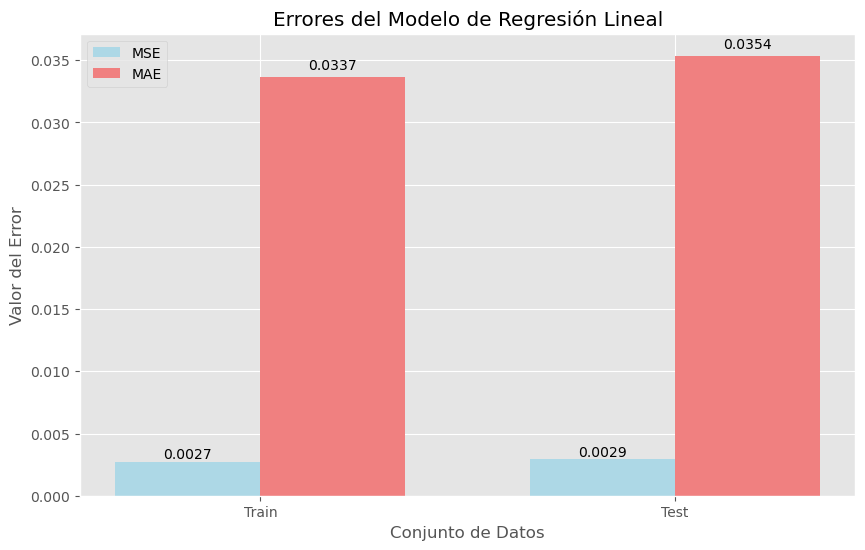

In [27]:
# Valores de los errores
mse_values = [mse_tr_lreg, mse_ts_lreg]
mae_values = [mae_tr_lreg, mae_ts_lreg]
error_types = ['Train', 'Test']

# Redondear los valores de los errores
mse_values_rounded = [round(value, 4) for value in mse_values]
mae_values_rounded = [round(value, 4) for value in mae_values]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types))

# Barra para el MSE
plt.bar(index, mse_values, bar_width, color='lightblue', label='MSE')

# Etiquetas de los valores de MSE
for i, value in enumerate(mse_values_rounded):
    plt.text(i, mse_values[i] + 0.01 * max(mse_values), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MAE
plt.bar(index + bar_width, mae_values, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de MAE
for i, value in enumerate(mae_values_rounded):
    plt.text(i + bar_width, mae_values[i] + 0.01 * max(mae_values), f'{value}', ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores del Modelo de Regresión Lineal')
plt.xticks(index + bar_width / 2, error_types)
plt.legend()
plt.show()




#### Propuesta:
Podemos probar esto mismo sin las variables que no son significativas a ver si mejoran los resultados.

In [78]:
# Define input and output matrices
INPUTS_reduced = ['ANNO', 'MES', 'UTILH_DiaAnterior','UTILH_DiaAnterior_x2',
          'UTILH_AñoAnterior',
                       'UTILH_TramoAnterior', 'UTILH_TramoPosterior', 'UTILH_TramoAnterior_x2', 
                       'UTILH_TramoPosterior_x2', 'UTILH_TramoAnterior_x3', 'UTILH_TramoPosterior_x3',
          'IRRAD_misma_hora', 'IRRADLH_AñoAnterior',
                       'IRRADH_TramoAnterior', 'IRRADH_TramoPosterior', 
                       'IRRADH_TramoAnterior_x2', 'IRRADH_TramoPosterior_x3']


OUTPUT = 'UTILH'

X = result_df[INPUTS_reduced] 
y = result_df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0) 

## Create dataset to store model predictions
dfTR_eval = X_train.copy() 
dfTR_eval['Y'] = y_train 
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

In [79]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_reduced)
])

# Definir el pipeline
pipe = Pipeline(steps=[
    ('Prep', preprocessor),  
    ('LinReg', LinearRegressor(fit_intercept=True))
])


nFolds = 10
param = {}  # En regresión no hay hiperparámetros
LR_fit = GridSearchCV(
    estimator=pipe,  # Estructura del modelo a utilizar
    param_grid=param,  # Cuadrícula definida para buscar
    n_jobs=-1,  # Número de núcleos a utilizar (paralelizar)
    scoring='neg_root_mean_squared_error',  # Función de puntuación
    cv=nFolds  # Número de pliegues
)

# Ajustar el modelo
LR_fit.fit(X_train[INPUTS_reduced], y_train)  # Búsqueda en la cuadrícula


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'UTILH_DiaAnterior',
                                                                          'UTILH_DiaAnterior_x2',
                                                                          'UTILH_AñoAnterior',
                                                                          'UTILH_TramoAnterior',
                                                                          'UTILH_TramoPosterior',
                                                                          'UTILH_TramoAnterior_x2',
                                                                          'UTILH_TramoPosterior_x2',
                                                                          'UTILH_TramoAnterior_x3',
                                                                          'UTILH_TramoPosterior_x3',
                                                                          'IRRAD_misma_hora',
                                                                          'IRRADLH_AñoAnterior',
                                                                          'IRRADH_TramoAnterior',
                                                                          'IRRADH_TramoPosterior',
                                                                          'IRRADH_TramoAnterior_x2',
                                                                          'IRRADH_TramoPosterior_x3'])])),
                                       ('LinReg', LinearRegressor())]),
             n_jobs=-1, param_grid={}, scoring='neg_root_mean_squared_error')

In [80]:
LR_fit.best_estimator_['LinReg'].summary(LR_fit.best_estimator_['Prep'].get_feature_names_out())

                            OLS Regression Results                            
Dep. Variable:                  UTILH   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.684e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:11:10   Log-Likelihood:                 21168.
No. Observations:               14028   AIC:                        -4.230e+04
Df Residuals:                   14010   BIC:                        -4.216e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
var                       coef            std err         t               P>|t|          
---------------------------------------------------------------------------
num__ANNO                 0.188           0.

In [81]:
dfTR_eval['LR_pred'] = LR_fit.predict(X_train)
dfTS_eval['LR_pred'] = LR_fit.predict(X_test)

mae_tr_lreg = mean_absolute_error(dfTR_eval['Y'], dfTR_eval['LR_pred'])
mae_ts_lreg = mean_absolute_error(dfTS_eval['Y'], dfTS_eval['LR_pred'])

mse_tr_lreg = mean_squared_error(dfTR_eval['Y'], dfTR_eval['LR_pred'])
mse_ts_lreg = mean_squared_error(dfTS_eval['Y'], dfTS_eval['LR_pred'])


print(f'MSE(TR) = {mse_tr_lreg}')
print(f'MSE(TS) = {mse_ts_lreg}')

print(f'MAE(TR) = {mae_tr_lreg}')
print(f'MAE(TS) = {mae_ts_lreg}')

MSE(TR) = 0.002863239829894714
MSE(TS) = 0.002669222062358376
MAE(TR) = 0.034599280317124774
MAE(TS) = 0.0332904875207174


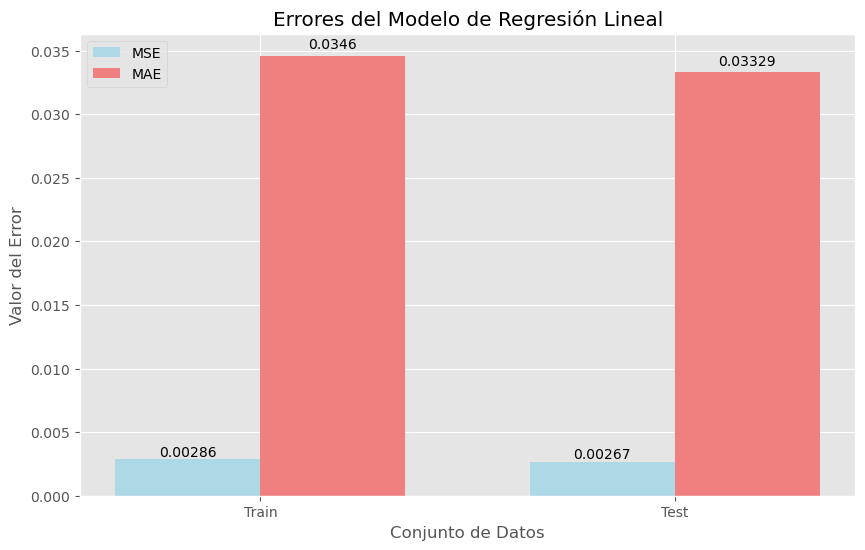

In [82]:
# Valores de los errores
mse_values = [mse_tr_lreg, mse_ts_lreg]
mae_values = [mae_tr_lreg, mae_ts_lreg]
error_types = ['Train', 'Test']

# Redondear los valores de los errores
mse_values_rounded = [round(value, 5) for value in mse_values]
mae_values_rounded = [round(value, 5) for value in mae_values]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types))

# Barra para el MSE
plt.bar(index, mse_values, bar_width, color='lightblue', label='MSE')

# Etiquetas de los valores de MSE
for i, value in enumerate(mse_values_rounded):
    plt.text(i, mse_values[i] + 0.01 * max(mse_values), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MAE
plt.bar(index + bar_width, mae_values, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de MAE
for i, value in enumerate(mae_values_rounded):
    plt.text(i + bar_width, mae_values[i] + 0.01 * max(mae_values), f'{value}', ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores del Modelo de Regresión Lineal')
plt.xticks(index + bar_width / 2, error_types)
plt.legend()
plt.show()


### 3.2) Simple Decision Tree

Para continuar, probamos con otro modelo previo a las técnicas de ensamblado, como puede ser un árbol de regresión sencillo, cuyos hiperparámetros tuneamos con GridSearch.

In [33]:
# VOLVEMOS A LOS INPUTS ORIGINALES

# Define input and output matrices
INPUTS = ['ANNO', 'MES', 'DIA', 'DIASEM', 'Tramo_Horario', 'UTILH_DiaAnterior','UTILH_DiaAnterior_x2',
          'UTILH_AñoAnterior',
                       'UTILH_TramoAnterior', 'UTILH_TramoPosterior', 'UTILH_TramoAnterior_x2', 
                       'UTILH_TramoPosterior_x2', 'UTILH_TramoAnterior_x3', 'UTILH_TramoPosterior_x3',
          'IRRAD_misma_hora', 'IRRADLH_AñoAnterior',
                       'IRRADH_TramoAnterior', 'IRRADH_TramoPosterior',
                      'IRRADH_TramoAnterior_x2', 'IRRADH_TramoPosterior_x2', 'IRRADH_TramoAnterior_x3', 'IRRADH_TramoPosterior_x3']

OUTPUT = 'UTILH'

X = result_df[INPUTS] 
y = result_df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0)
## Create dataset to store model predictions
dfTR_eval = X_train.copy() 
dfTR_eval['Y'] = y_train 
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

In [34]:
warnings.filterwarnings('ignore')

## Inputs of the model
INPUTS_DT = INPUTS

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS)
])


param = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting


pipe = Pipeline(steps=[
    ('Prep', preprocessor),  
    ('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure
                                                    random_state=150))
])


nFolds = 3
single_reg_tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds en validación cruzada

single_reg_tree_fit.fit(X_train, y_train) # Search in grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'Tramo_Horario',
                                                                          'UTILH_DiaAnterior',
                                                                          'UTILH_DiaAnterior_x2',
                                                                          'UTILH_AñoAnterior',
                                                                          'UTILH_TramoAnterior',
                                                                          'UTILH_TramoPosterior',
                                                                          'UTILH_TramoAnterior_x2',
                                                                          'UTILH_TramoPosterior_x2',
                                                                          'UTILH_Tr...
                                                                          'IRRADH_TramoAnterior',
                                                                          'IRRADH_TramoPosterior',
                                                                          'IRRADH_TramoAnterior_x2',
                                                                          'IRRADH_TramoPosterior_x2',
                                                                          'IRRADH_TramoAnterior_x3',
                                                                          'IRRADH_TramoPosterior_x3'])])),
                                       ('DT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

Text(0.5, 1.0, 'Single tree')

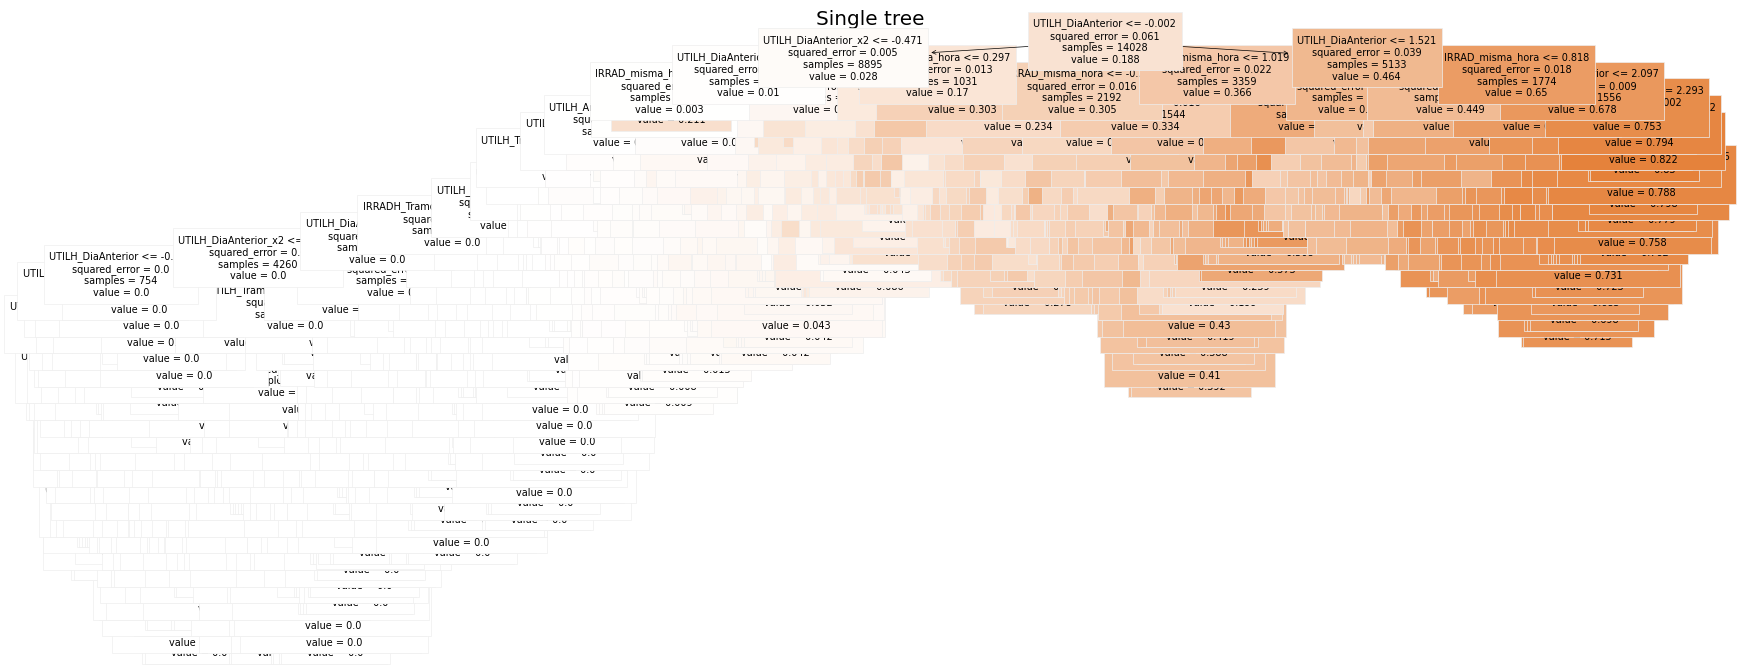

In [35]:
## Plot the decision tree model
plt.figure(figsize=(20, 8))
plot_tree(single_reg_tree_fit.best_estimator_['DT'],
          feature_names= INPUTS,
          fontsize=7, filled=True)
plt.title('Single tree')

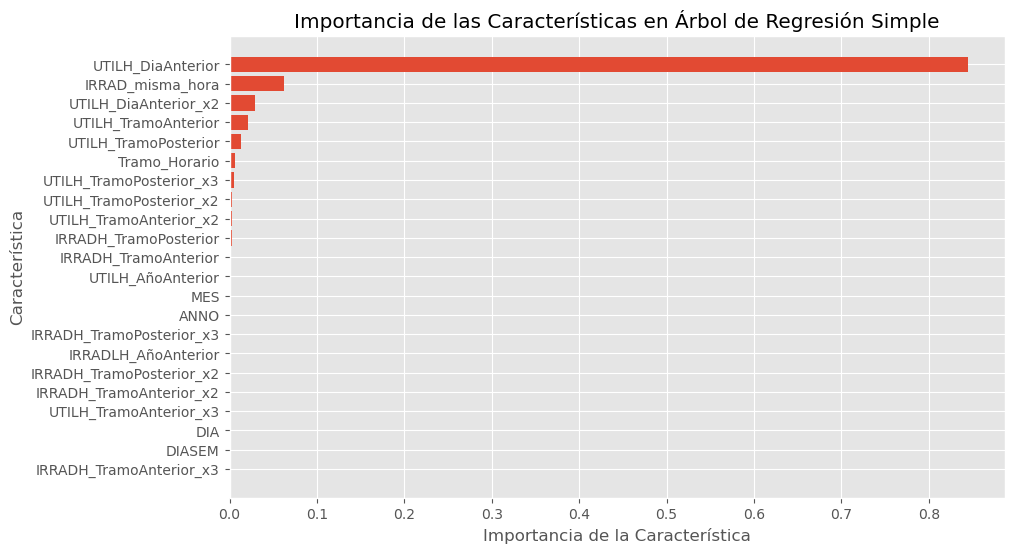

In [36]:
# Obtener la importancia de las características
feature_importance = single_reg_tree_fit.best_estimator_['DT'].feature_importances_

# Nombre de las características
feature_names = INPUTS_DT

# Ordenar los índices de acuerdo a la importancia
sorted_idx = feature_importance.argsort()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de las Características en Árbol de Regresión Simple')
plt.show()


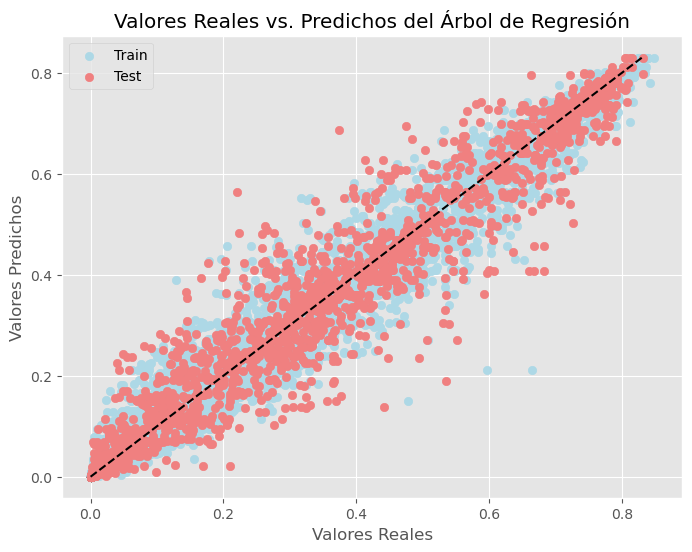

In [37]:
# Plot de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_train, single_reg_tree_fit.predict(X_train), color='lightblue', label='Train')
plt.scatter(y_test, single_reg_tree_fit.predict(X_test), color='lightcoral', label='Test')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs. Predichos del Árbol de Regresión')
plt.legend()
plt.show()

In [38]:
warnings.filterwarnings('ignore')

y_train_est = single_reg_tree_fit.best_estimator_['DT'].predict(X_train)
y_test_est = single_reg_tree_fit.best_estimator_['DT'].predict(X_test)

mse_tr_dt = np.mean((y_train - y_train_est)**2)
mse_ts_dt = np.mean((y_test - y_test_est)**2)

mae_tr_dt = np.mean(np.abs(y_train - y_train_est))
mae_ts_dt = np.mean(np.abs(y_test - y_test_est))


print(f'MSE(TR) = {mse_tr_dt}')
print(f'MSE(TS) = {mse_ts_dt}')

print(f'MAE(TR) = {mae_tr_dt}')
print(f'MAE(TS) = {mae_ts_dt}')


MSE(TR) = 0.0732978455711979
MSE(TS) = 0.07329110896268108
MAE(TR) = 0.25045303393816115
MAE(TS) = 0.25004751405935755


In [39]:
real = X_train[['ANNO', 'MES', 'DIA', 'Tramo_Horario']]
real['real'] = y_train
real['pred'] = y_train_est
real_sorted = real.sort_values(by=['ANNO', 'MES', 'DIA', 'Tramo_Horario'], ascending=[True, True, True, True])
real_ = real_sorted
print(real_sorted)

       ANNO  MES  DIA  Tramo_Horario      real      pred
0      2015    1    1              0  0.000018  0.306098
1      2015    1    1              3  0.000024  0.306098
2      2015    1    1              6  0.046463  0.306098
3      2015    1    1              9  0.596802  0.367163
4      2015    1    1             12  0.665174  0.367163
...     ...  ...  ...            ...       ...       ...
17530  2020   12   31              6  0.006679  0.306098
17531  2020   12   31              9  0.116855  0.367163
17532  2020   12   31             12  0.145188  0.367163
17533  2020   12   31             15  0.031015  0.367163
17534  2020   12   31             18  0.000007  0.306098

[14028 rows x 6 columns]


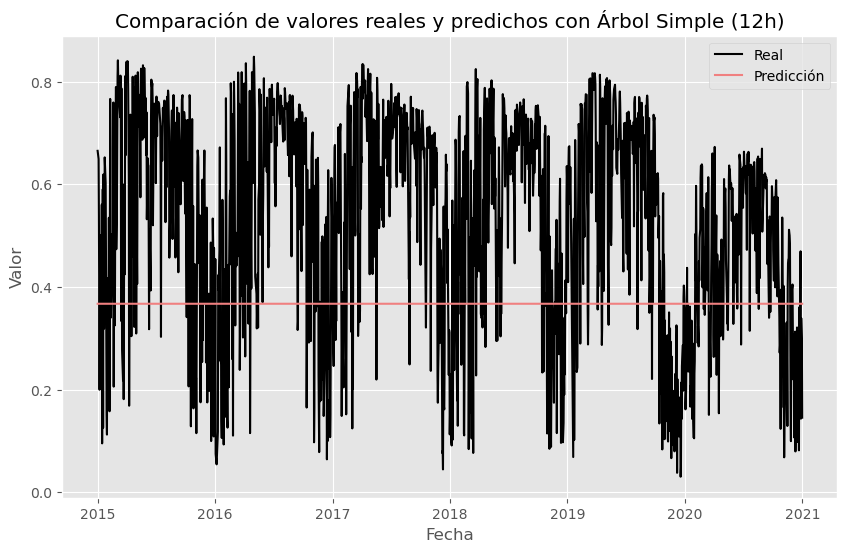

In [40]:
# filtro tramo horario = 12
real_sorted = real_[real_['Tramo_Horario'] == 12]


real_sorted['ANNO'] = real_sorted['ANNO'].astype(str)
real_sorted['MES'] = real_sorted['MES'].astype(str)
real_sorted['DIA'] = real_sorted['DIA'].astype(str)

# Unir las columnas 'ANNO', 'MES' y 'DIA' para formar una cadena de fecha
real_sorted['Fecha'] = real_sorted['ANNO'] + '-' + real_sorted['MES'] + '-' + real_sorted['DIA']

# Convertir la columna 'Fecha' a datetime
real_sorted['Fecha'] = pd.to_datetime(real_sorted['Fecha'])

# Trazar las series de tiempo
plt.figure(figsize=(10, 6))
plt.plot(real_sorted['Fecha'], real_sorted['real'], label='Real', color='black')
plt.plot(real_sorted['Fecha'], real_sorted['pred'], label='Predicción', color='lightcoral')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de valores reales y predichos con Árbol Simple (12h)')
plt.legend()
plt.show()


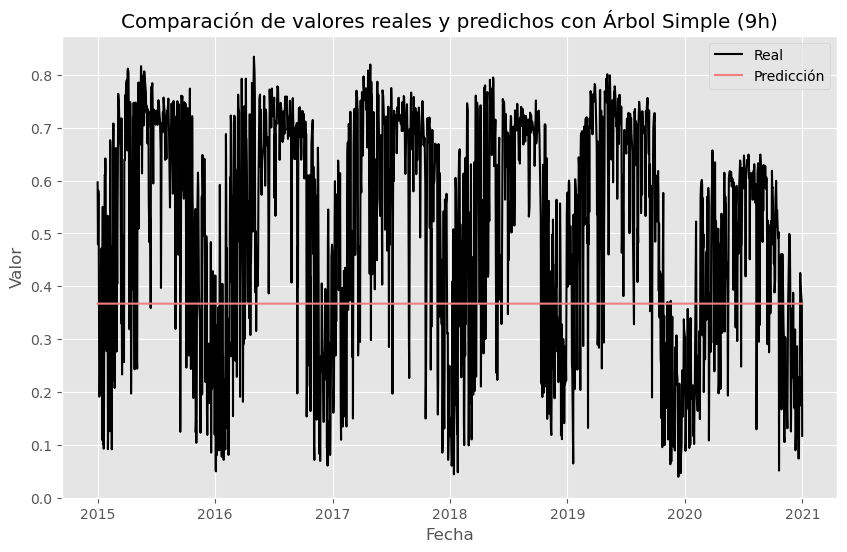

In [41]:
# filtro tramo horario = 12
real_sorted = real_[real_['Tramo_Horario'] == 9]


real_sorted['ANNO'] = real_sorted['ANNO'].astype(str)
real_sorted['MES'] = real_sorted['MES'].astype(str)
real_sorted['DIA'] = real_sorted['DIA'].astype(str)

# Unir las columnas 'ANNO', 'MES' y 'DIA' para formar una cadena de fecha
real_sorted['Fecha'] = real_sorted['ANNO'] + '-' + real_sorted['MES'] + '-' + real_sorted['DIA']

# Convertir la columna 'Fecha' a datetime
real_sorted['Fecha'] = pd.to_datetime(real_sorted['Fecha'])

# Trazar las series de tiempo
plt.figure(figsize=(10, 6))
plt.plot(real_sorted['Fecha'], real_sorted['real'], label='Real', color='black')
plt.plot(real_sorted['Fecha'], real_sorted['pred'], label='Predicción', color='lightcoral')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de valores reales y predichos con Árbol Simple (9h)')
plt.legend()
plt.show()

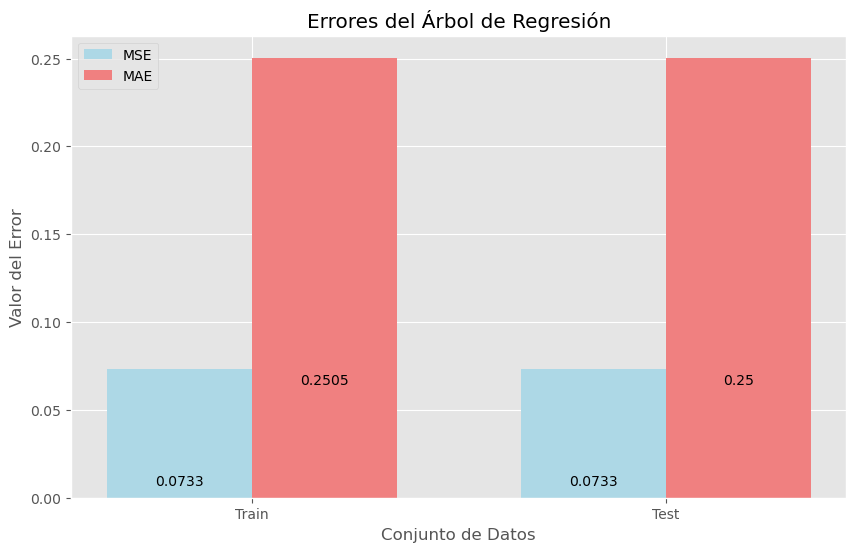

In [42]:
# Valores de los errores
mse_values = [mse_tr_dt, mse_ts_dt]
mae_values = [mae_tr_dt, mae_ts_dt]
error_types = ['Train', 'Test']

# Redondear los valores de los errores
mse_values_rounded = [round(value, 4) for value in mse_values]
mae_values_rounded = [round(value, 4) for value in mae_values]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types))

# Barra para el MSE
plt.bar(index, mse_values, bar_width, color='lightblue', label='MSE')

# Etiquetas de los valores de MSE
for i, value in enumerate(mse_values_rounded):
    plt.text(i, mse_values[i]  * max(mse_values), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MAE
plt.bar(index + bar_width, mae_values, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de MAE
for i, value in enumerate(mae_values_rounded):
    plt.text(i + bar_width, mae_values[i] * max(mae_values), f'{value}', ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores del Árbol de Regresión')
plt.xticks(index + bar_width / 2, error_types)
plt.legend()
plt.show()


## ENSAMBLE

Ahora ya sí, pasamos a los modelos de ensamble.

En primer lugar, un árbol de Bagging.

### 3.3) Bagged Tree

El método Bagged Trees es un enfoque de ensamble que combina múltiples árboles de decisión entrenados en diferentes subconjuntos de datos de entrenamiento, con el objetivo de mejorar la precisión predictiva y reducir el sobreajuste.

In [43]:
warnings.filterwarnings('ignore')


# creo 1º el base estimator de los arboles
base_estimator =  Pipeline(steps=[('BT', 
                                    DecisionTreeRegressor( criterion='squared_error',  # impurity measure
                                                          min_impurity_decrease = 0.001,
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=10, # Minimum number of obs in a terminal node
                                                          random_state=999))]) # For replication

# Respuesta
param = {'BT__n_estimators': range(20, 150, 5)
        }

pipe = Pipeline(steps= [('BT',
                        BaggingRegressor(estimator=base_estimator,
                                        random_state=999))])

nFolds = 3
BT_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                      scoring = 'neg_mean_absolute_error',
                      cv=nFolds) # Number of Folds 

INPUTS_ = INPUTS  
BT_fit.fit(X_train, y_train) # Search in grid


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('BT',
                                        BaggingRegressor(estimator=Pipeline(steps=[('BT',
                                                                                    DecisionTreeRegressor(min_impurity_decrease=0.001,
                                                                                                          min_samples_leaf=10,
                                                                                                          random_state=999))]),
                                                         random_state=999))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='neg_mean_absolute_error')

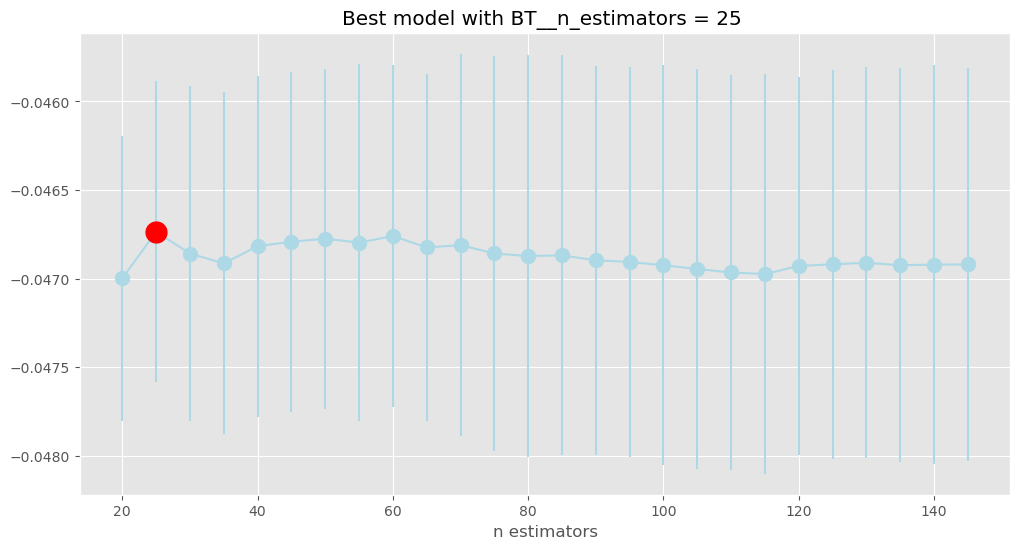

In [44]:
MT.plotModelGridError(BT_fit)

In [45]:
y_train_bt = BT_fit.best_estimator_['BT'].predict(X_train)
y_test_bt = BT_fit.best_estimator_['BT'].predict(X_test)

mse_tr_bt = np.mean((y_train - y_train_bt)**2)
mse_ts_bt = np.mean((y_test - y_test_bt)**2)

mae_tr_bt = np.mean(np.abs(y_train - y_train_bt))
mae_ts_bt = np.mean(np.abs(y_test - y_test_bt))


print(f'MSE(TR) = {mse_tr_bt}')
print(f'MSE(TS) = {mse_ts_bt}')

print(f'MAE(TR) = {mae_tr_bt}')
print(f'MAE(TS) = {mae_ts_bt}')


MSE(TR) = 0.006166649939255781
MSE(TS) = 0.006382513354055988
MAE(TR) = 0.04664586906616094
MAE(TS) = 0.04746468760466275


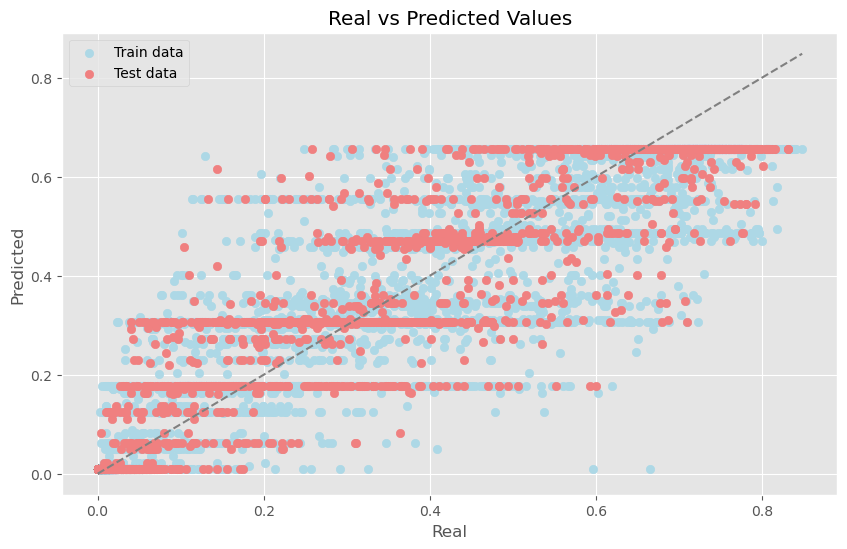

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, BT_fit.predict(X_train), color='lightblue', label='Train data')
plt.scatter(y_test, BT_fit.predict(X_test), color='lightcoral', label='Test data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='gray')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Real vs Predicted Values')
plt.legend()
plt.show()


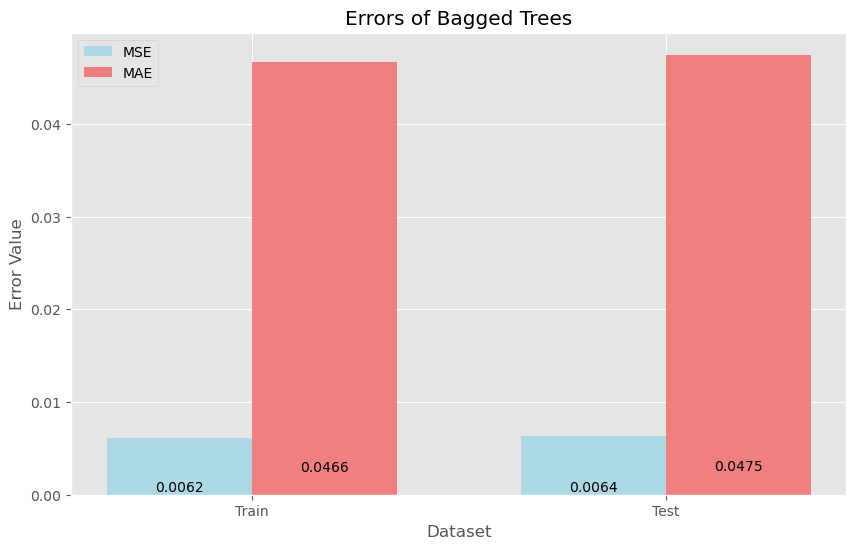

In [47]:
# 3. Gráfico de barras de errores con etiquetas
mse_tr_bt = np.mean((y_train - BT_fit.predict(X_train))**2)
mse_ts_bt = np.mean((y_test - BT_fit.predict(X_test))**2)
mae_tr_bt = np.mean(np.abs(y_train - BT_fit.predict(X_train)))
mae_ts_bt = np.mean(np.abs(y_test - BT_fit.predict(X_test)))

mse_values_bt = [mse_tr_bt, mse_ts_bt]
mae_values_bt = [mae_tr_bt, mae_ts_bt]
error_types_bt = ['Train', 'Test']

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types_bt))

plt.bar(index, mse_values_bt, bar_width, color='lightblue', label='MSE')
plt.bar(index + bar_width, mae_values_bt, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de errores
for i, value in enumerate(mse_values_bt):
    plt.text(i, mse_values_bt[i]  * max(mse_values_bt), f'{round(value, 4)}', ha='center', va='bottom', fontsize=10)

for i, value in enumerate(mae_values_bt):
    plt.text(i + bar_width, mae_values_bt[i]  * max(mae_values_bt), f'{round(value, 4)}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Dataset')
plt.ylabel('Error Value')
plt.title('Errors of Bagged Trees')
plt.xticks(index + bar_width / 2, error_types_bt)
plt.legend()
plt.show()

### 3.4) Random Forest:

Probamos a continuación con un Random Forest.

Random Forest es preferible a un Bagged Tree porque además de entrenar múltiples árboles en subconjuntos aleatorios de datos, también utiliza un subconjunto aleatorio de características en cada árbol, lo que aumenta la diversidad y la robustez del modelo, reduciendo aún más el riesgo de sobreajuste y mejorando la precisión predictiva.

In [48]:
warnings.filterwarnings('ignore')

param = {'RF__max_features': range(1, 6, 1), # Number number of features to consider when looking for the best split
        'RF__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.1), #0.001), # Minimum impurity to decrease in each split
        'RF__min_samples_leaf': np.arange(1,10,5), #1), # Minimum number of obs in a terminal node
         'RF__min_samples_split':  np.arange(1,10,5), #1)
         'RF__n_estimators': range(20, 150, 5)} # Number of trees in the forest

# Crear el pipeline con el imputador y el regresor de Gradient Boosting
base_estimator = Pipeline(steps=[
    ('RF', 
                                    RandomForestRegressor(criterion='squared_error',  # impurity measure
                                                            random_state=999))
])


nFolds = 3
RF_fit = GridSearchCV(estimator=base_estimator, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 

INPUTS_RF = INPUTS  
RF_fit.fit(X_train, y_train) # Search in grid


# Ver todos los parámetros del modelo
RF_fit.get_params()


{'cv': 3,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('RF', RandomForestRegressor(random_state=999))],
 'estimator__verbose': False,
 'estimator__RF': RandomForestRegressor(random_state=999),
 'estimator__RF__bootstrap': True,
 'estimator__RF__ccp_alpha': 0.0,
 'estimator__RF__criterion': 'squared_error',
 'estimator__RF__max_depth': None,
 'estimator__RF__max_features': 1.0,
 'estimator__RF__max_leaf_nodes': None,
 'estimator__RF__max_samples': None,
 'estimator__RF__min_impurity_decrease': 0.0,
 'estimator__RF__min_samples_leaf': 1,
 'estimator__RF__min_samples_split': 2,
 'estimator__RF__min_weight_fraction_leaf': 0.0,
 'estimator__RF__n_estimators': 100,
 'estimator__RF__n_jobs': None,
 'estimator__RF__oob_score': False,
 'estimator__RF__random_state': 999,
 'estimator__RF__verbose': 0,
 'estimator__RF__warm_start': False,
 'estimator': Pipeline(steps=[('RF', RandomForestRegressor(random_state=999))]),
 'n_jobs': -1,
 'param_grid': {'RF__max_features': r

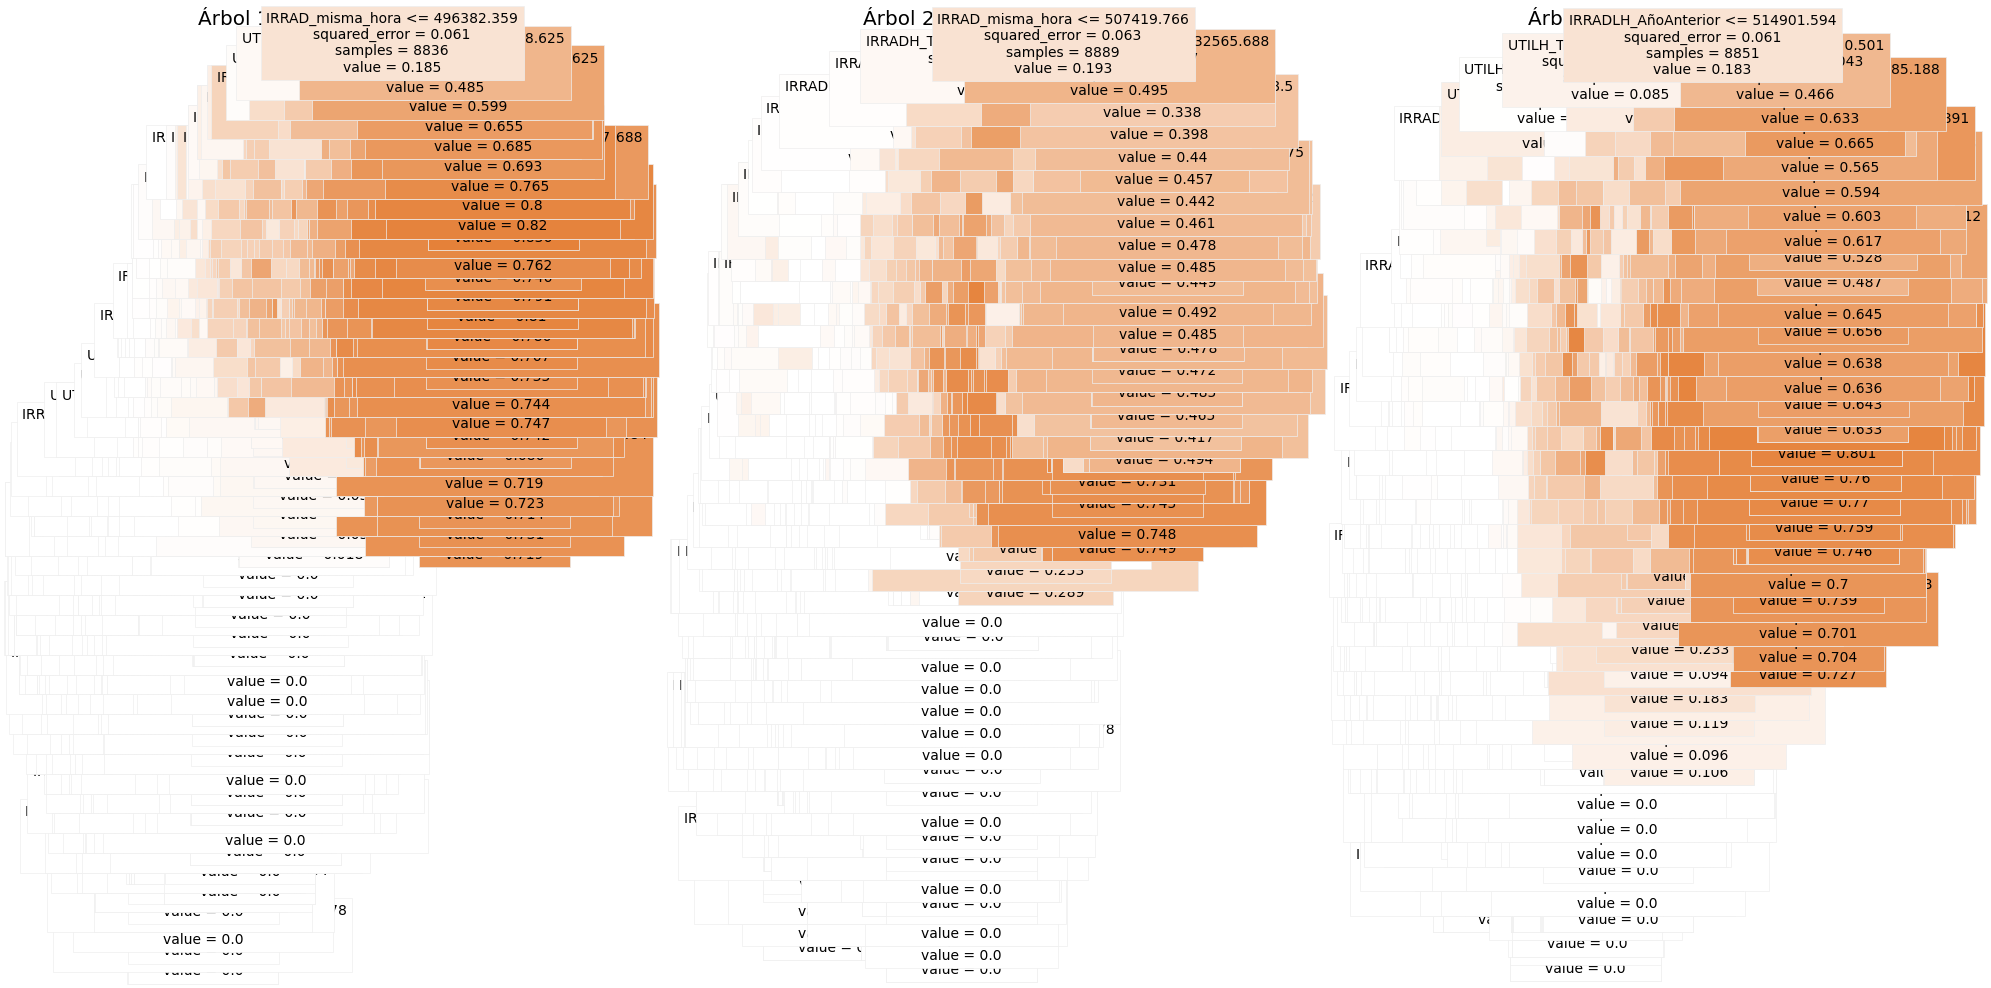

In [49]:
from sklearn import tree
import matplotlib.pyplot as plt

# Obtener los tres primeros árboles del modelo Random Forest
trees_rf = RF_fit.best_estimator_['RF'].estimators_[:3]

# Crear un gráfico con 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# Iterar sobre los árboles y sus respectivos subplots
for i, tree_rf in enumerate(trees_rf):
    ax = axes[i]
    tree.plot_tree(tree_rf, ax=ax, feature_names=INPUTS_RF, filled=True, fontsize=10)
    ax.set_title(f'Árbol {i+1} del Random Forest')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


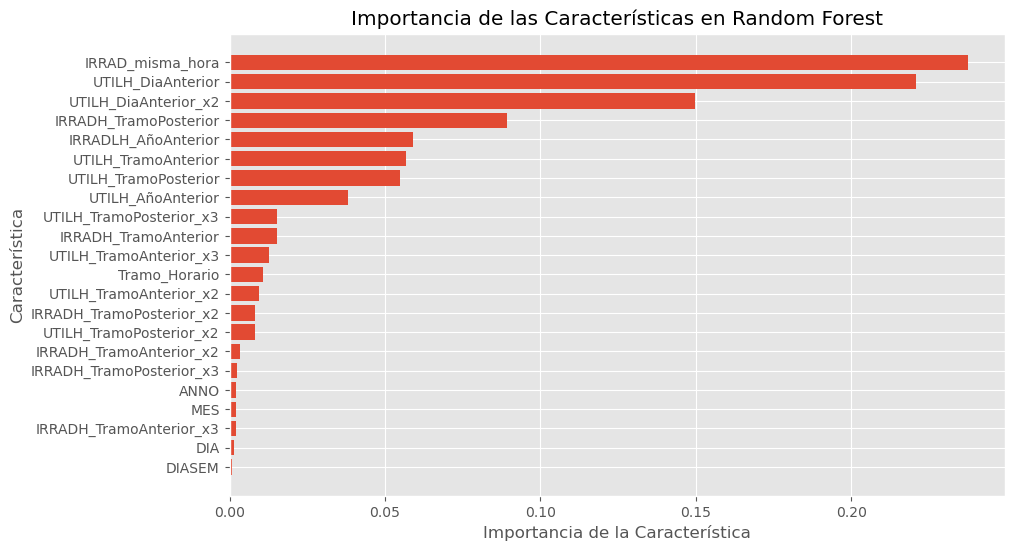

In [50]:
# Obtener la importancia de las características
feature_importance = RF_fit.best_estimator_['RF'].feature_importances_

# Nombre de las características
feature_names = X_train.columns

# Ordenar los índices de acuerdo a la importancia
sorted_idx = feature_importance.argsort()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de las Características en Random Forest')
plt.show()


In [51]:
##  Compute errors
y_train_est_rf =  RF_fit.predict(X_train)
y_test_est_rf =  RF_fit.predict(X_test)

mse_tr_rf = np.mean((y_train - y_train_est_rf)**2)
mse_ts_rf = np.mean((y_test - y_test_est_rf)**2)

mae_tr_rf = np.mean(np.abs(y_train - y_train_est_rf))
mae_ts_rf = np.mean(np.abs(y_test - y_test_est_rf))

print(f'MSE(TR) = {mse_tr_rf}')
print(f'MSE(TS) = {mse_ts_rf}')

print(f'MAE(TR) = {mae_tr_rf}')
print(f'MAE(TS) = {mae_ts_rf}')

MSE(TR) = 0.00036432679632869845
MSE(TS) = 0.001617254607327041
MAE(TR) = 0.009546304342736345
MAE(TS) = 0.020538897187218786


In [52]:
real = X_train[['ANNO', 'MES', 'DIA', 'Tramo_Horario']]
real['real'] = y_train
real['pred'] = y_train_est_rf
real_sorted = real.sort_values(by=['ANNO', 'MES', 'DIA', 'Tramo_Horario'], ascending=[True, True, True, True])
real_ = real_sorted
print(real_sorted)

       ANNO  MES  DIA  Tramo_Horario      real      pred
0      2015    1    1              0  0.000018  0.029657
1      2015    1    1              3  0.000024  0.030087
2      2015    1    1              6  0.046463  0.045638
3      2015    1    1              9  0.596802  0.400498
4      2015    1    1             12  0.665174  0.461385
...     ...  ...  ...            ...       ...       ...
17530  2020   12   31              6  0.006679  0.012946
17531  2020   12   31              9  0.116855  0.120074
17532  2020   12   31             12  0.145188  0.144257
17533  2020   12   31             15  0.031015  0.034608
17534  2020   12   31             18  0.000007  0.000009

[14028 rows x 6 columns]


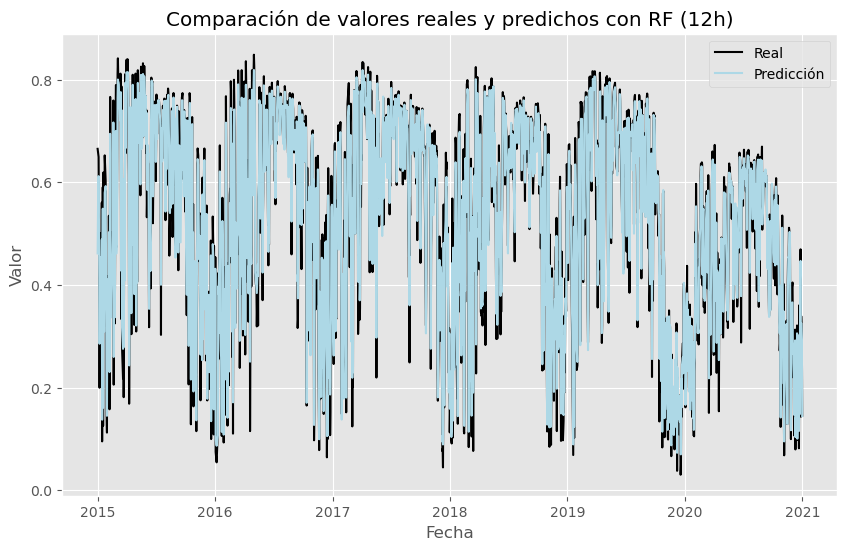

In [53]:
# filtro tramo horario = 12
real_sorted = real_[real_['Tramo_Horario'] == 12]


real_sorted['ANNO'] = real_sorted['ANNO'].astype(str)
real_sorted['MES'] = real_sorted['MES'].astype(str)
real_sorted['DIA'] = real_sorted['DIA'].astype(str)

# Unir las columnas 'ANNO', 'MES' y 'DIA' para formar una cadena de fecha
real_sorted['Fecha'] = real_sorted['ANNO'] + '-' + real_sorted['MES'] + '-' + real_sorted['DIA']

# Convertir la columna 'Fecha' a datetime
real_sorted['Fecha'] = pd.to_datetime(real_sorted['Fecha'])

# Trazar las series de tiempo
plt.figure(figsize=(10, 6))
plt.plot(real_sorted['Fecha'], real_sorted['real'], label='Real', color='black')
plt.plot(real_sorted['Fecha'], real_sorted['pred'], label='Predicción', color='lightblue')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de valores reales y predichos con RF (12h)')
plt.legend()
plt.show()


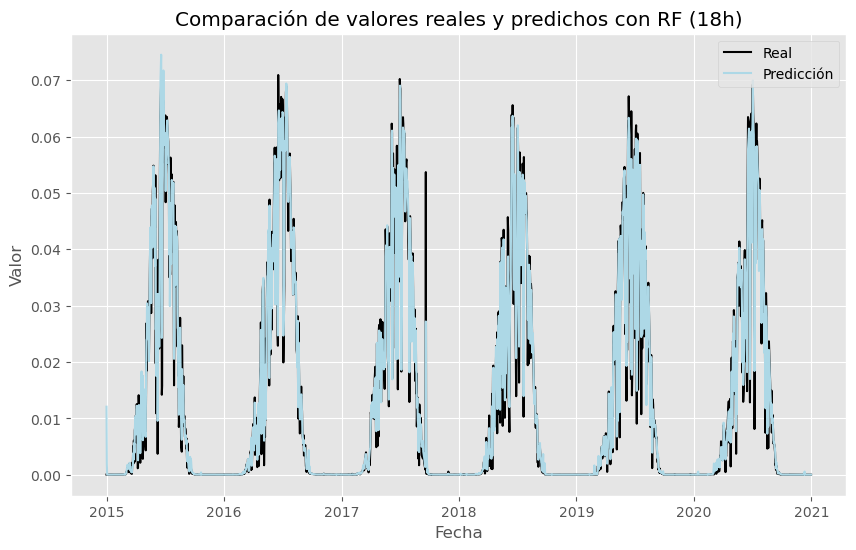

In [54]:
# filtro tramo horario = 18
real_sorted = real_[real_['Tramo_Horario'] == 18]


real_sorted['ANNO'] = real_sorted['ANNO'].astype(str)
real_sorted['MES'] = real_sorted['MES'].astype(str)
real_sorted['DIA'] = real_sorted['DIA'].astype(str)

# Unir las columnas 'ANNO', 'MES' y 'DIA' para formar una cadena de fecha
real_sorted['Fecha'] = real_sorted['ANNO'] + '-' + real_sorted['MES'] + '-' + real_sorted['DIA']

# Convertir la columna 'Fecha' a datetime
real_sorted['Fecha'] = pd.to_datetime(real_sorted['Fecha'])

# Trazar las series de tiempo
plt.figure(figsize=(10, 6))
plt.plot(real_sorted['Fecha'], real_sorted['real'], label='Real', color='black')
plt.plot(real_sorted['Fecha'], real_sorted['pred'], label='Predicción', color='lightblue')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de valores reales y predichos con RF (18h)')
plt.legend()
plt.show()

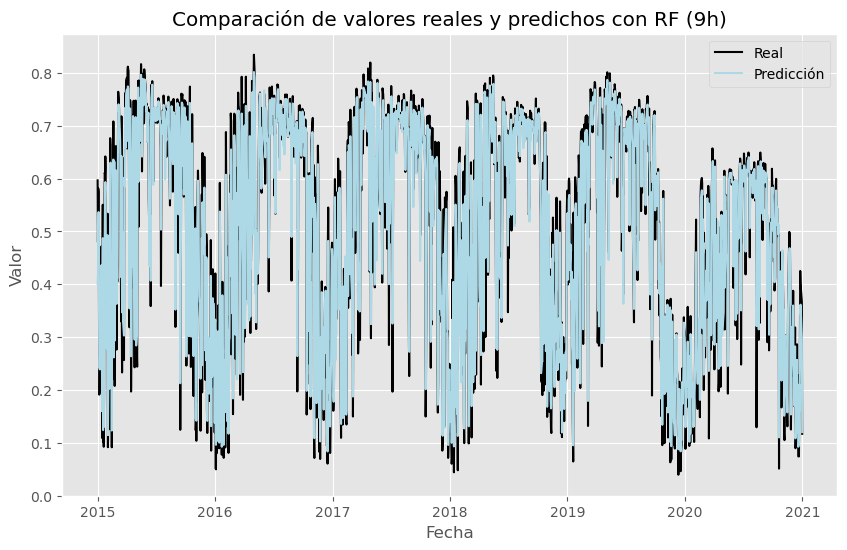

In [55]:
# filtro tramo horario = 9
real_sorted = real_[real_['Tramo_Horario'] == 9]


real_sorted['ANNO'] = real_sorted['ANNO'].astype(str)
real_sorted['MES'] = real_sorted['MES'].astype(str)
real_sorted['DIA'] = real_sorted['DIA'].astype(str)

# Unir las columnas 'ANNO', 'MES' y 'DIA' para formar una cadena de fecha
real_sorted['Fecha'] = real_sorted['ANNO'] + '-' + real_sorted['MES'] + '-' + real_sorted['DIA']

# Convertir la columna 'Fecha' a datetime
real_sorted['Fecha'] = pd.to_datetime(real_sorted['Fecha'])

# Trazar las series de tiempo
plt.figure(figsize=(10, 6))
plt.plot(real_sorted['Fecha'], real_sorted['real'], label='Real', color='black')
plt.plot(real_sorted['Fecha'], real_sorted['pred'], label='Predicción', color='lightblue')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de valores reales y predichos con RF (9h)')
plt.legend()
plt.show()

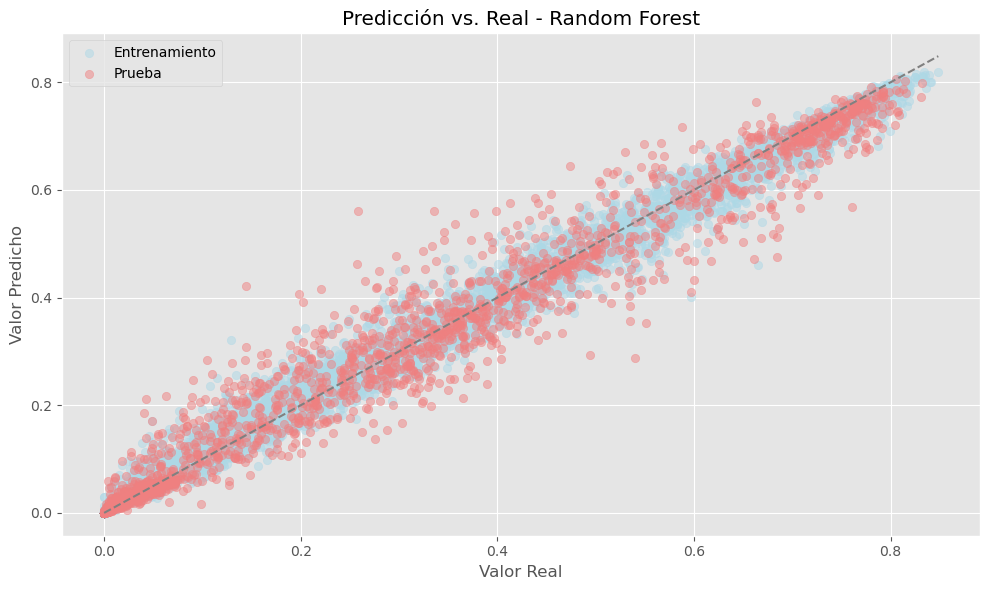

In [56]:
# Gráfico de predicción vs. real
plt.figure(figsize=(10, 6))

# Predicciones vs. valores reales para el conjunto de entrenamiento
plt.scatter(y_train, y_train_est_rf, color='lightblue', label='Entrenamiento', alpha=0.5)

# Predicciones vs. valores reales para el conjunto de prueba
plt.scatter(y_test, y_test_est_rf, color='lightcoral', label='Prueba', alpha=0.5)

# Personalizar el gráfico
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='gray')
plt.title('Predicción vs. Real - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


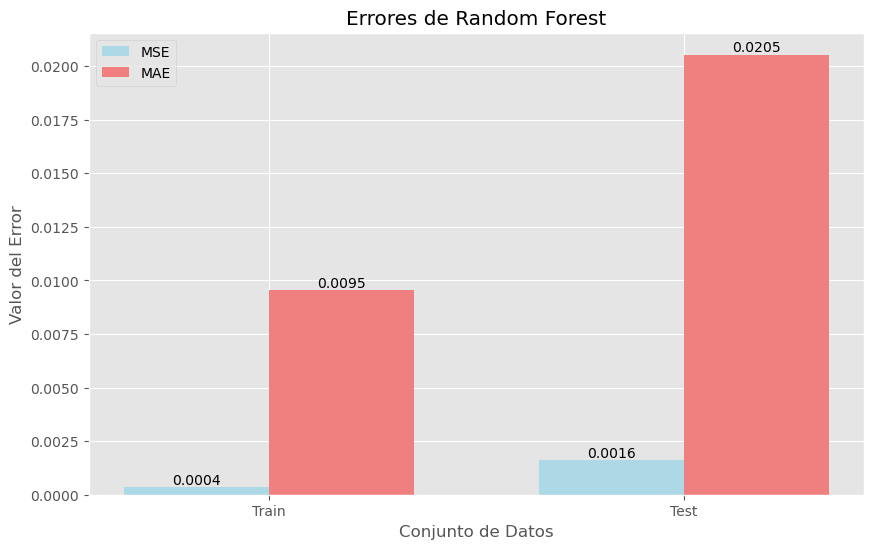

In [57]:
# Valores de los errores
mse_values_rf = [mse_tr_rf, mse_ts_rf]
mae_values_rf = [mae_tr_rf, mae_ts_rf]
error_types_rf = ['Train', 'Test']

# Redondear los valores de los errores
mse_values_rf_rounded = [round(value, 4) for value in mse_values_rf]
mae_values_rf_rounded = [round(value, 4) for value in mae_values_rf]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types_rf))

# Barra para el MSE
plt.bar(index, mse_values_rf, bar_width, color='lightblue', label='MSE')

# Etiquetas de los valores de MSE
for i, value in enumerate(mse_values_rf_rounded):
    plt.text(i, mse_values_rf[i] , str(value), ha='center', va='bottom', fontsize=10)

# Barra para el MAE
plt.bar(index + bar_width, mae_values_rf, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de MAE
for i, value in enumerate(mae_values_rf_rounded):
    plt.text(i + bar_width, mae_values_rf[i] , str(value), ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores de Random Forest')
plt.xticks(index + bar_width / 2, error_types_rf)
plt.legend()
plt.show()


### 3.5) AdaBoost:

AdaBoost es un algoritmo de aprendizaje automático que mejora iterativamente la precisión del modelo al enfocarse en las instancias que son más difíciles de clasificar. Utiliza un conjunto de modelos de aprendizaje débil, como árboles de decisión simples, y asigna un peso a cada instancia de entrenamiento, priorizando aquellas que fueron clasificadas incorrectamente en las iteraciones anteriores. Esto permite construir un modelo fuerte a partir de varios modelos débiles, lo que puede llevar a un mejor rendimiento en comparación con un solo modelo.

In [58]:
warnings.filterwarnings('ignore')

n_estimators=5000
max_depth = 4
min_impurity_decrease =  0.001 * np.var(y_train)
AdaBoost_reg_tree_fit = AdaBoostRegressor(
                                DecisionTreeRegressor(max_depth=max_depth,
                                                      min_impurity_decrease=min_impurity_decrease), 
                                n_estimators=n_estimators,

                                random_state=999)

AdaBoost_reg_tree_fit.fit(X_train, y_train)
AdaBoost_reg_tree_fit.get_params()


{'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': 4,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 6.137405143632597e-05,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(max_depth=4, min_impurity_decrease=6.137405143632597e-05),
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 5000,
 'random_state': 999}

In [59]:
##  Compute errors
y_train_ab =  AdaBoost_reg_tree_fit.predict(X_train)
y_test_ab =  AdaBoost_reg_tree_fit.predict(X_test)

mse_tr_ab = np.mean((y_train - y_train_ab)**2)
mse_ts_ab = np.mean((y_test - y_test_ab)**2)

mae_tr_ab = np.mean(np.abs(y_train - y_train_ab))
mae_ts_ab = np.mean(np.abs(y_test - y_test_ab))

print(f'MSE(TR) = {mse_tr_ab}')
print(f'MSE(TS) = {mse_ts_ab}')

print(f'MAE(TR) = {mae_tr_ab}')
print(f'MAE(TS) = {mae_ts_ab}')

MSE(TR) = 0.007533481752696977
MSE(TS) = 0.007681773869637745
MAE(TR) = 0.0797210005261595
MAE(TS) = 0.08006304499603734


### 3.6) GradientBoosting:

Finalmente, llegamos a GradientBoosting.

Gradient Boosting es preferido sobre AdaBoost debido a su capacidad para optimizar directamente cualquier función de pérdida diferenciable, lo que permite una mayor flexibilidad en la optimización del modelo. Además, Gradient Boosting puede manejar eficazmente datos heterogéneos y ruidosos, y tiende a ser más robusto frente al sobreajuste.


#### 1) Prueba 1: con todas las variables explicativas

In [60]:
warnings.filterwarnings('ignore')

# Definir el diccionario de parámetros para GridSearchCV
param = {'GB__n_estimators': range(20, 150, 50),
         'GB__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train), 0.1),
         'GB__min_samples_leaf': np.arange(1, 10, 5),
         'GB__min_samples_split': np.arange(1, 10, 5)}

# Crear el pipeline con el imputador y el regresor de Gradient Boosting
base_estimator = Pipeline(steps=[
    ('GB', GradientBoostingRegressor(criterion='squared_error', random_state=999))
])

# Usar Grid Search Cross Validation para encontrar los mejores parámetros
nFolds = 3
GB_fit = GridSearchCV(estimator=base_estimator,
                       param_grid=param,
                       n_jobs=-1,
                       cv=nFolds)

# Ajustar el modelo
GB_fit.fit(X_train, y_train)

# Ver todos los parámetros
#GB_fit.get_params()

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('GB',
                                        GradientBoostingRegressor(criterion='squared_error',
                                                                  random_state=999))]),
             n_jobs=-1,
             param_grid={'GB__min_impurity_decrease': array([0.]),
                         'GB__min_samples_leaf': array([1, 6]),
                         'GB__min_samples_split': array([1, 6]),
                         'GB__n_estimators': range(20, 150, 50)})

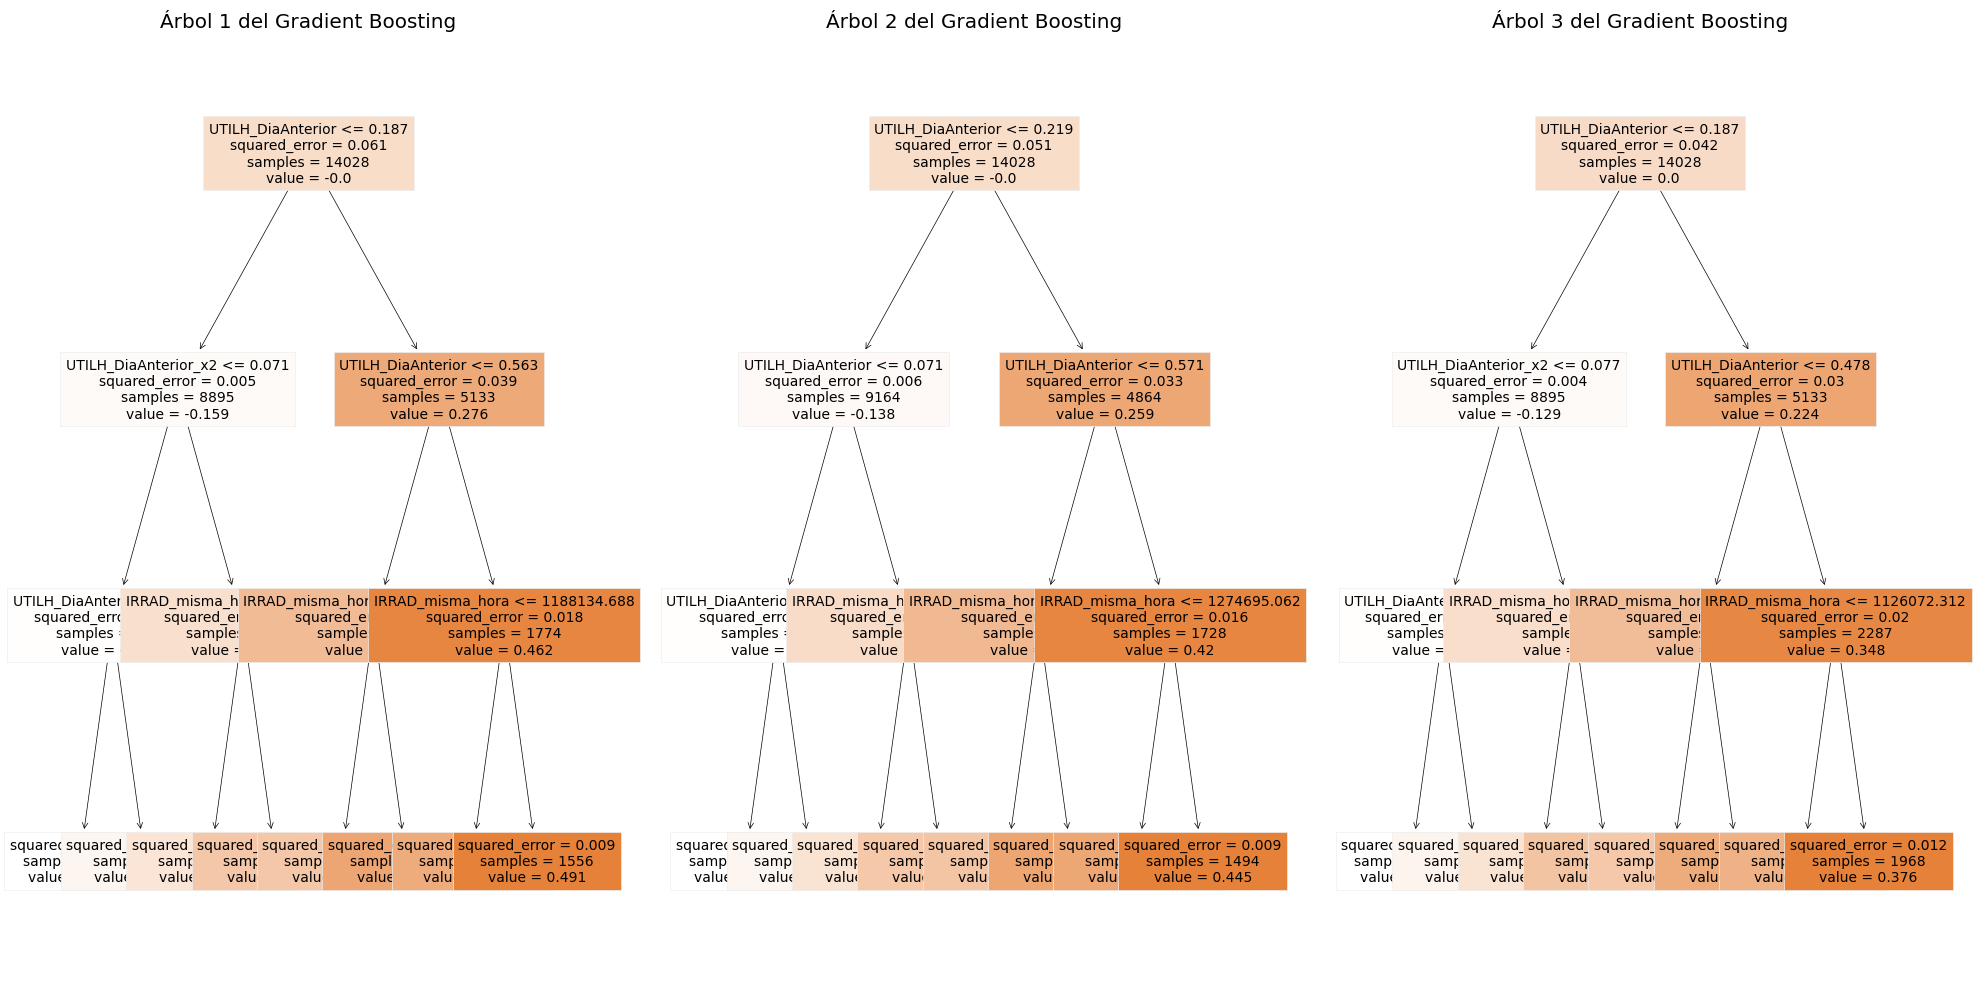

In [61]:
# Obtener los tres primeros árboles del modelo Gradient Boosting
trees_gb = GB_fit.best_estimator_['GB'].estimators_[:3]

# Crear un gráfico con 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# Iterar sobre los árboles y sus respectivos subplots
for i, tree_gb in enumerate(trees_gb):
    ax = axes[i]
    tree.plot_tree(tree_gb[0], ax=ax, feature_names=INPUTS, filled=True, fontsize=10)
    ax.set_title(f'Árbol {i+1} del Gradient Boosting')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


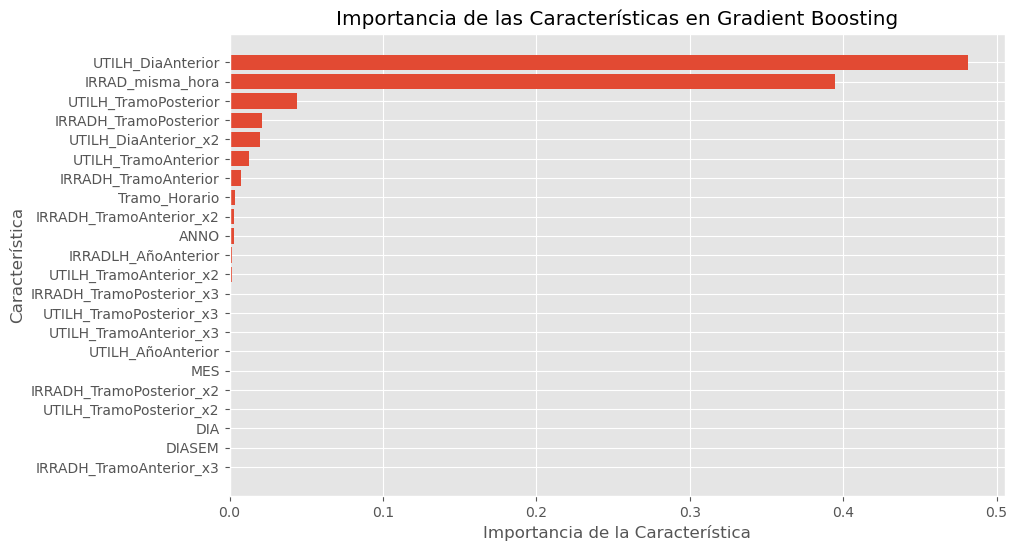

In [62]:
# Obtener la importancia de las características
feature_importance = GB_fit.best_estimator_['GB'].feature_importances_

# Nombre de las características
feature_names = X_train.columns

# Ordenar los índices de acuerdo a la importancia
sorted_idx = feature_importance.argsort()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de las Características en Gradient Boosting')
plt.show()


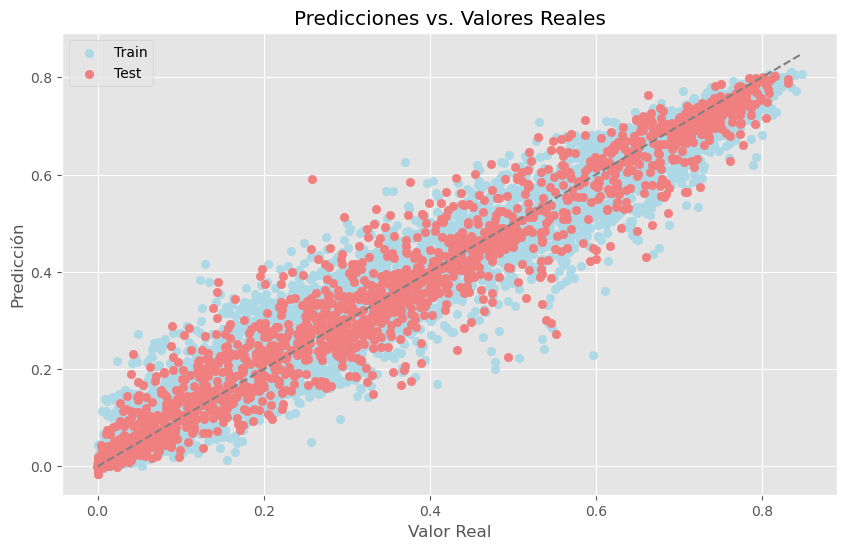

In [63]:
# Realizar predicciones en el conjunto de entrenamiento y prueba
y_pred_train = GB_fit.predict(X_train)
y_pred_test = GB_fit.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, color='lightblue', label='Train')
plt.scatter(y_test, y_pred_test, color='lightcoral', label='Test')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='gray')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Predicciones vs. Valores Reales')
plt.legend()
plt.show()


In [64]:
# Compute errors
y_train_est =  GB_fit.predict(X_train)
y_test_est =  GB_fit.predict(X_test)

mse_tr_gb = np.mean((y_train - y_train_est)**2)
mse_ts_gb = np.mean((y_test - y_test_est)**2)

mae_tr_gb = np.mean(np.abs(y_train - y_train_est))
mae_ts_gb = np.mean(np.abs(y_test - y_test_est))

print(f'MSE(TR) = {mse_tr_gb}')
print(f'MSE(TS) = {mse_ts_gb}')

print(f'MAE(TR) = {mae_tr_gb}')
print(f'MAE(TS) = {mae_ts_gb}')



MSE(TR) = 0.0014271979996532407
MSE(TS) = 0.0018110006764423254
MAE(TR) = 0.019786672533024057
MAE(TS) = 0.0221006126070325


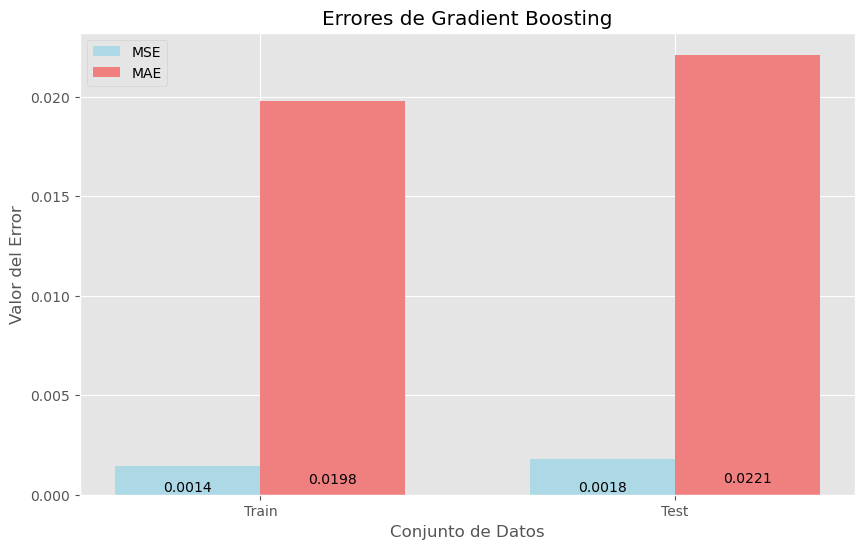

In [65]:
# Valores de los errores
mse_values_gb = [mse_tr_gb, mse_ts_gb]
mae_values_gb = [mae_tr_gb, mae_ts_gb]
error_types_gb = ['Train', 'Test']

# Redondear los valores de los errores
mse_values_gb_rounded = [round(value, 4) for value in mse_values_gb]
mae_values_gb_rounded = [round(value, 4) for value in mae_values_gb]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types_gb))

# Barra para el MSE
plt.bar(index, mse_values_gb, bar_width, color='lightblue', label='MSE')

# Etiquetas de los valores de MSE
for i, value in enumerate(mse_values_gb_rounded):
    plt.text(i, mse_values_gb[i] * max(mse_values_gb), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MAE
plt.bar(index + bar_width, mae_values_gb, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de MAE
for i, value in enumerate(mae_values_gb_rounded):
    plt.text(i + bar_width, mae_values_gb[i]* max(mae_values_gb), f'{value}', ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores de Gradient Boosting')
plt.xticks(index + bar_width / 2, error_types_gb)
plt.legend()
plt.show()


#### Prueba 2: solo variables significativas:

In [66]:
# Define input and output matrices
INPUTS = ['ANNO', 'UTILH_DiaAnterior','UTILH_DiaAnterior_x2', 'UTILH_TramoAnterior', 'UTILH_TramoPosterior', 
         'UTILH_TramoPosterior_x3',
          'IRRAD_misma_hora', 'IRRADH_TramoAnterior_x2', 'IRRADH_TramoPosterior']

OUTPUT = 'UTILH'

X = result_df[INPUTS] 
y = result_df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0)
## Create dataset to store model predictions
dfTR_eval = X_train.copy() 
dfTR_eval['Y'] = y_train 
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

In [67]:
warnings.filterwarnings('ignore')

# Definir el diccionario de parámetros para GridSearchCV
param = {'GB__n_estimators': range(20, 150, 50),
         'GB__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train), 0.1),
         'GB__min_samples_leaf': np.arange(1, 10, 5),
         'GB__min_samples_split': np.arange(1, 10, 5)}

# Crear el pipeline con el imputador y el regresor de Gradient Boosting
base_estimator = Pipeline(steps=[
    ('GB', GradientBoostingRegressor(criterion='squared_error', random_state=999))
])

# Usar Grid Search Cross Validation para encontrar los mejores parámetros
nFolds = 3
GB_fit2 = GridSearchCV(estimator=base_estimator,
                       param_grid=param,
                       n_jobs=-1,
                       cv=nFolds)

# Ajustar el modelo
GB_fit2.fit(X_train, y_train)

# Ver todos los parámetros
#GB_fit.get_params()

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('GB',
                                        GradientBoostingRegressor(criterion='squared_error',
                                                                  random_state=999))]),
             n_jobs=-1,
             param_grid={'GB__min_impurity_decrease': array([0.]),
                         'GB__min_samples_leaf': array([1, 6]),
                         'GB__min_samples_split': array([1, 6]),
                         'GB__n_estimators': range(20, 150, 50)})

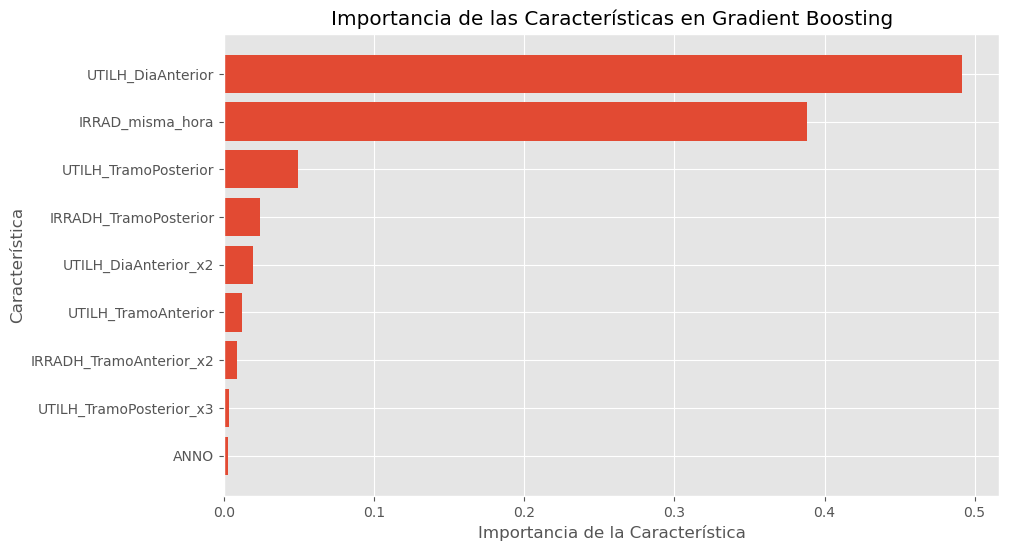

In [68]:
# Obtener la importancia de las características
feature_importance = GB_fit2.best_estimator_['GB'].feature_importances_

# Nombre de las características
feature_names = X_train.columns

# Ordenar los índices de acuerdo a la importancia
sorted_idx = feature_importance.argsort()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de las Características en Gradient Boosting')
plt.show()


In [69]:
# Compute errors
y_train_est2 =  GB_fit2.predict(X_train)
y_test_est2 =  GB_fit2.predict(X_test)

mse_tr_gb2 = np.mean((y_train - y_train_est2)**2)
mse_ts_gb2 = np.mean((y_test - y_test_est2)**2)

mae_tr_gb2 = np.mean(np.abs(y_train - y_train_est2))
mae_ts_gb2 = np.mean(np.abs(y_test - y_test_est2))

print(f'MSE(TR) = {mse_tr_gb2}')
print(f'MSE(TS) = {mse_ts_gb2}')

print(f'MAE(TR) = {mae_tr_gb2}')
print(f'MAE(TS) = {mae_ts_gb2}')


MSE(TR) = 0.0017981369550597488
MSE(TS) = 0.0021937603314674146
MAE(TR) = 0.02179282672538013
MAE(TS) = 0.02389167420977005


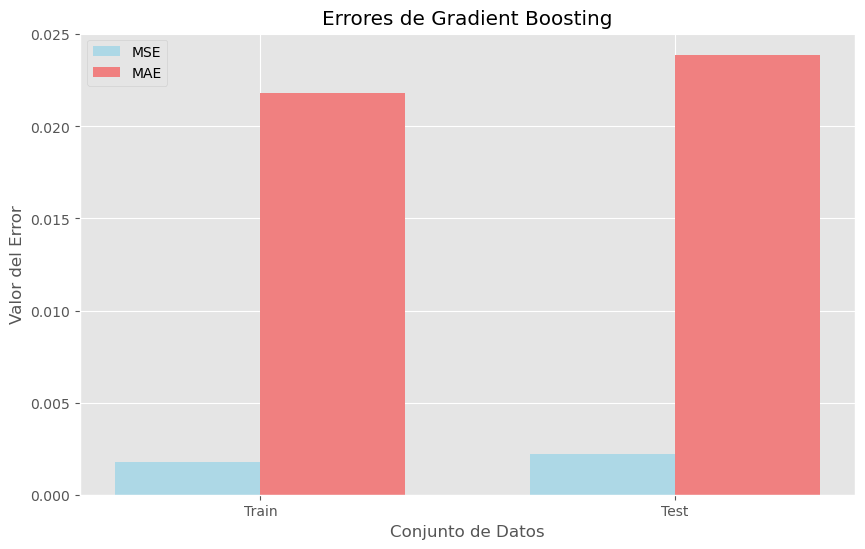

In [70]:
# Valores de los errores
mse_values = [mse_tr_gb2, mse_ts_gb2]
mae_values = [mae_tr_gb2, mae_ts_gb2]
error_types = ['Train', 'Test']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types))

# Barra para el MSE
plt.bar(index, mse_values, bar_width, color='lightblue', label='MSE')

# Barra para el MAE
plt.bar(index + bar_width, mae_values, bar_width, color='lightcoral', label='MAE')

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores de Gradient Boosting')
plt.xticks(index + bar_width / 2, error_types)
plt.legend()
plt.show()

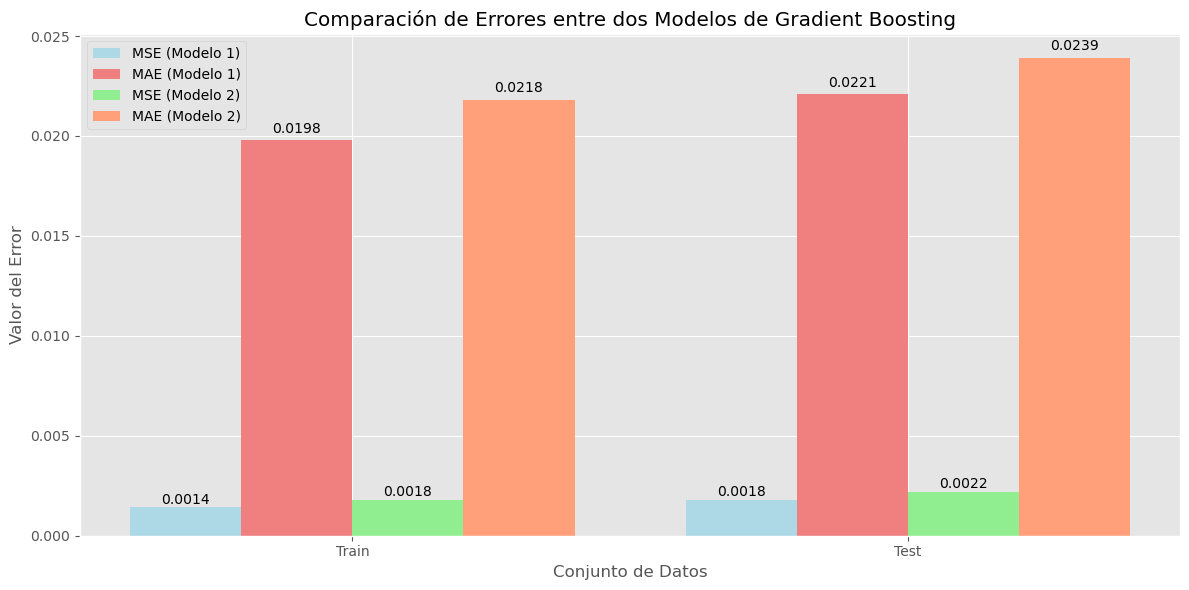

In [71]:
# Valores de los errores adicionales
mse_values_gb2 = [mse_tr_gb2, mse_ts_gb2]
mae_values_gb2 = [mae_tr_gb2, mae_ts_gb2]
error_types_gb2 = ['Train', 'Test']

# Redondear los valores de los errores adicionales
mse_values_gb2_rounded = [round(value, 4) for value in mse_values_gb2]
mae_values_gb2_rounded = [round(value, 4) for value in mae_values_gb2]

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(error_types_gb))

# Barra para el MSE (Modelo 1)
plt.bar(index - 1.5*bar_width, mse_values_gb, bar_width, color='lightblue', label='MSE (Modelo 1)')

# Etiquetas de los valores de MSE (Modelo 1)
for i, value in enumerate(mse_values_gb_rounded):
    plt.text(i - 1.5*bar_width, mse_values_gb[i] + 0.01 * max(mse_values_gb), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MAE (Modelo 1)
plt.bar(index - 0.5*bar_width, mae_values_gb, bar_width, color='lightcoral', label='MAE (Modelo 1)')

# Etiquetas de los valores de MAE (Modelo 1)
for i, value in enumerate(mae_values_gb_rounded):
    plt.text(i - 0.5*bar_width, mae_values_gb[i] + 0.01 * max(mae_values_gb), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MSE (Modelo 2)
plt.bar(index + 0.5*bar_width, mse_values_gb2, bar_width, color='lightgreen', label='MSE (Modelo 2)')

# Etiquetas de los valores de MSE (Modelo 2)
for i, value in enumerate(mse_values_gb2_rounded):
    plt.text(i + 0.5*bar_width, mse_values_gb2[i] + 0.01 * max(mse_values_gb2), f'{value}', ha='center', va='bottom', fontsize=10)

# Barra para el MAE (Modelo 2)
plt.bar(index + 1.5*bar_width, mae_values_gb2, bar_width, color='lightsalmon', label='MAE (Modelo 2)')

# Etiquetas de los valores de MAE (Modelo 2)
for i, value in enumerate(mae_values_gb2_rounded):
    plt.text(i + 1.5*bar_width, mae_values_gb2[i] + 0.01 * max(mae_values_gb2), f'{value}', ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Comparación de Errores entre dos Modelos de Gradient Boosting')
plt.xticks(index, error_types_gb)
plt.legend()
plt.tight_layout()
plt.show()


## 4) Comparación errores modelos:

In [72]:
print("--- Errores MSE obtenidos en el train ----")
print(f'Linear Regresion = {round(mse_tr_lreg, 4)}')
print(f'Decision Tree = {round(mse_tr_dt, 4)}')
print(f'Bagged Tree = {round(mse_tr_bt, 4)}')
print(f'Random Forest = {round(mse_tr_rf, 4)}')
print(f'Gradient Boosting = {round(mse_tr_gb, 4)}')
print("")

print("--- Errores MSE obtenidos en el test ----")
print(f'Linear Regresion = {round(mse_ts_lreg, 4)}')
print(f'Decision Tree = {round(mse_ts_dt, 4)}')
print(f'Bagged Tree = {round(mse_ts_bt, 4)}')
print(f'Random Forest = {round(mse_ts_rf, 4)}')
print(f'Gradient Boosting = {round(mse_ts_gb, 4)}')
print("")

--- Errores MSE obtenidos en el train ----
Linear Regresion = 0.0028
Decision Tree = 0.0733
Bagged Tree = 0.0062
Random Forest = 0.0004
Gradient Boosting = 0.0014

--- Errores MSE obtenidos en el test ----
Linear Regresion = 0.0026
Decision Tree = 0.0733
Bagged Tree = 0.0064
Random Forest = 0.0016
Gradient Boosting = 0.0018



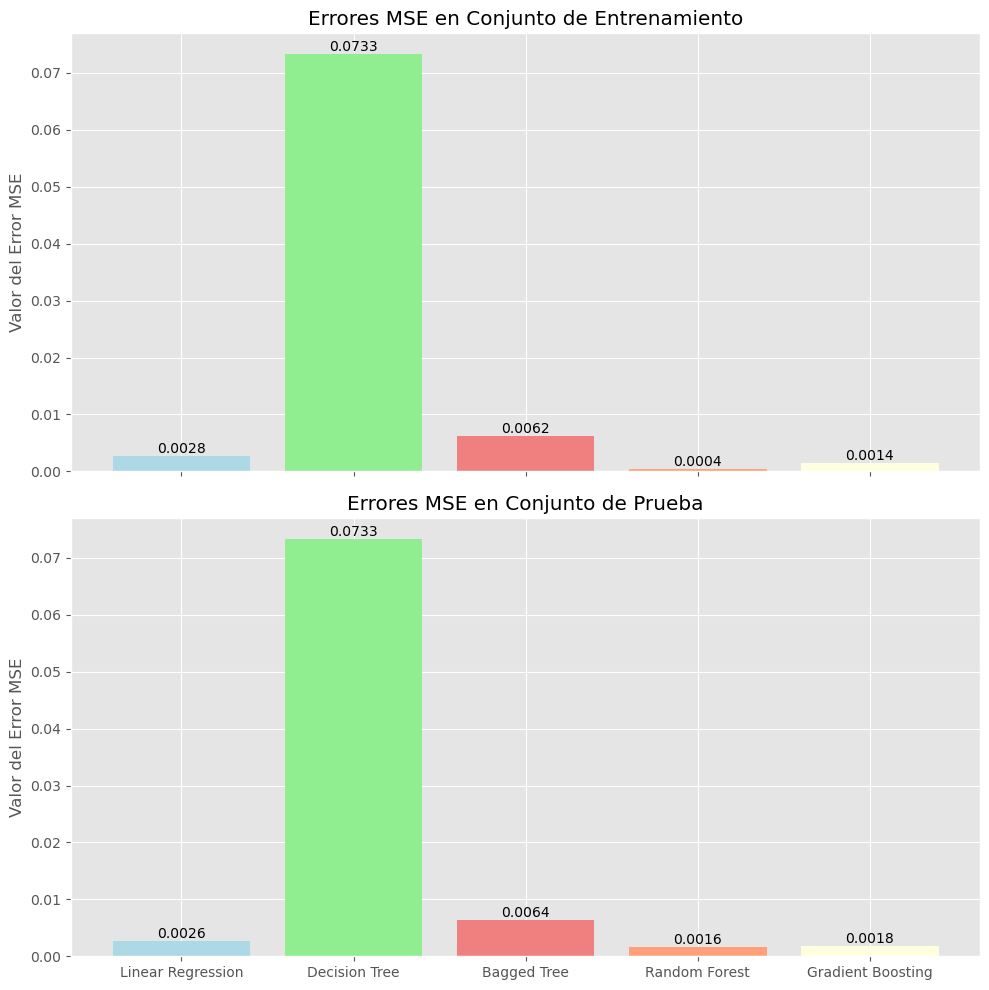

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Errores MSE obtenidos en el conjunto de entrenamiento
mse_train_values = [mse_tr_lreg, mse_tr_dt, mse_tr_bt, mse_tr_rf, mse_tr_gb]
models_train = ['Linear Regression', 'Decision Tree', 'Bagged Tree', 'Random Forest', 'Gradient Boosting']

# Errores MSE obtenidos en el conjunto de prueba
mse_test_values = [mse_ts_lreg, mse_ts_dt, mse_ts_bt, mse_ts_rf, mse_ts_gb]
models_test = ['Linear Regression', 'Decision Tree', 'Bagged Tree', 'Random Forest', 'Gradient Boosting']

# Crear figura y subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Barras para errores MSE en conjunto de entrenamiento
axs[0].bar(models_train, mse_train_values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightyellow'])
axs[0].set_ylabel('Valor del Error MSE')
axs[0].set_title('Errores MSE en Conjunto de Entrenamiento')
axs[0].grid(True)

# Barras para errores MSE en conjunto de prueba
axs[1].bar(models_test, mse_test_values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightyellow'])
axs[1].set_ylabel('Valor del Error MSE')
axs[1].set_title('Errores MSE en Conjunto de Prueba')
axs[1].grid(True)

# Añadir etiquetas
for ax in axs:
    for i, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height(), str(round(v.get_height(), 4)), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [74]:
print("--- Errores MAE obtenidos en el train ----")
print(f'Linear Regresion = {round(mae_tr_lreg, 4)}')
print(f'Decision Tree = {round(mae_tr_dt, 4)}')
print(f'Bagged Tree = {round(mae_tr_bt, 4)}')
print(f'Random Forest = {round(mae_tr_rf, 4)}')
print(f'Gradient Boosting = {round(mae_tr_gb, 4)}')
print("")

print("--- Errores MAE obtenidos en el test ----")
print(f'Linear Regresion = {round(mae_ts_lreg, 4)}')
print(f'Decision Tree = {round(mae_ts_dt, 4)}')
print(f'Bagged Tree = {round(mae_ts_bt, 4)}')
print(f'Random Forest = {round(mae_ts_rf, 4)}')
print(f'Gradient Boosting = {round(mae_ts_gb, 4)}')
print("")

--- Errores MAE obtenidos en el train ----
Linear Regresion = 0.0341
Decision Tree = 0.2505
Bagged Tree = 0.0466
Random Forest = 0.0095
Gradient Boosting = 0.0198

--- Errores MAE obtenidos en el test ----
Linear Regresion = 0.033
Decision Tree = 0.25
Bagged Tree = 0.0475
Random Forest = 0.0205
Gradient Boosting = 0.0221



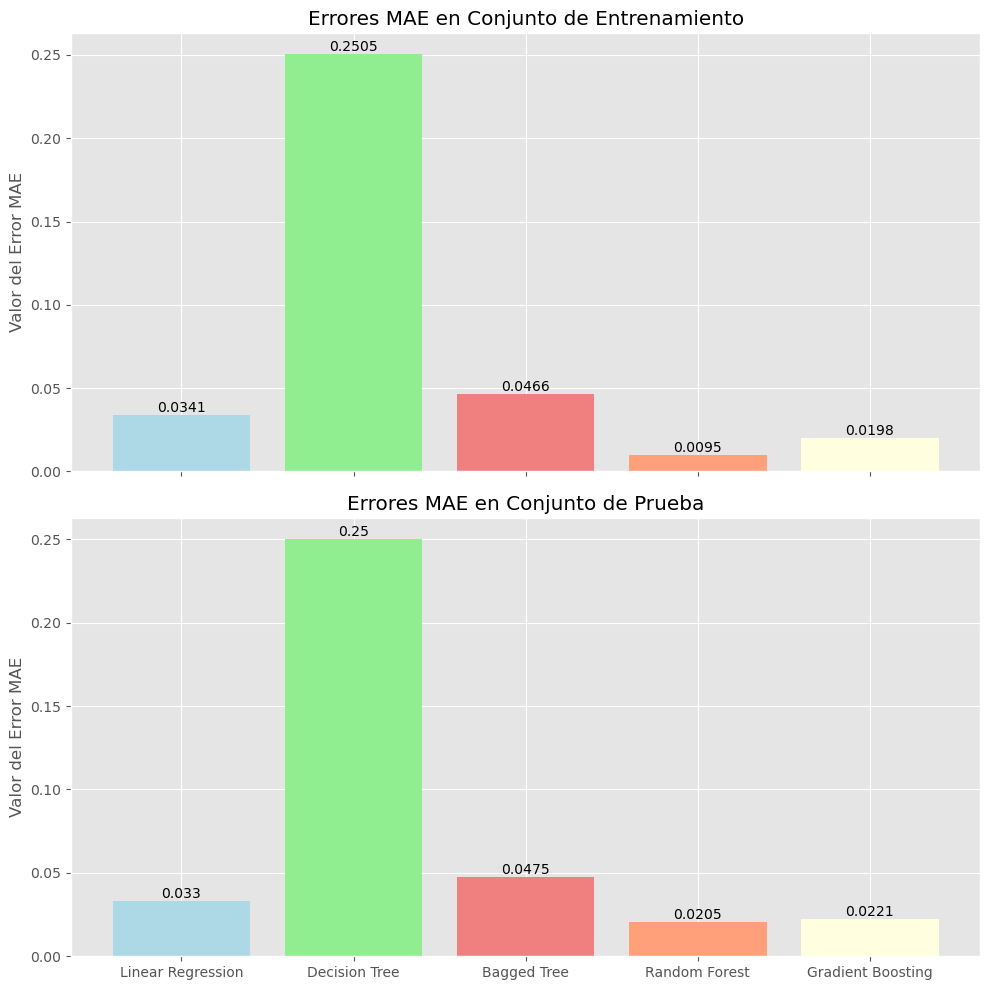

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Errores MAE obtenidos en el conjunto de entrenamiento
mae_train_values = [mae_tr_lreg, mae_tr_dt, mae_tr_bt, mae_tr_rf, mae_tr_gb]
models_train = ['Linear Regression', 'Decision Tree', 'Bagged Tree', 'Random Forest', 'Gradient Boosting']

# Errores MAE obtenidos en el conjunto de prueba
mae_test_values = [mae_ts_lreg, mae_ts_dt, mae_ts_bt, mae_ts_rf, mae_ts_gb]
models_test = ['Linear Regression', 'Decision Tree', 'Bagged Tree', 'Random Forest', 'Gradient Boosting']

# Crear figura y subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Barras para errores MAE en conjunto de entrenamiento
axs[0].bar(models_train, mae_train_values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightyellow'])
axs[0].set_ylabel('Valor del Error MAE')
axs[0].set_title('Errores MAE en Conjunto de Entrenamiento')
axs[0].grid(True)

# Barras para errores MAE en conjunto de prueba
axs[1].bar(models_test, mae_test_values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightyellow'])
axs[1].set_ylabel('Valor del Error MAE')
axs[1].set_title('Errores MAE en Conjunto de Prueba')
axs[1].grid(True)

# Añadir etiquetas
for ax in axs:
    for i, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height(), str(round(v.get_height(), 4)), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Predicción FINAL sobre el test separado:

In [83]:
warnings.filterwarnings('ignore')


best_params = {'max_features': 1, 
               'min_impurity_decrease': 0.0, 
               'min_samples_leaf': 1, 
               'min_samples_split': 2, 
               'n_estimators': 100}

optimal_estimator = Pipeline(steps=[('RF', 
                                     RandomForestRegressor(criterion='squared_error', 
                                                           random_state=999, 
                                                           **best_params))])

optimal_estimator.fit(X_0, y_0)


Pipeline(steps=[('RF',
                 RandomForestRegressor(max_features=1, random_state=999))])

In [84]:
# Compute errors
y_train_est =  RF_fit.predict(X_0)
y_test_est =  RF_fit.predict(X_test_final)

mse_tr_rf = np.mean((y_0 - y_train_est)**2)
mse_ts_rf = np.mean((y_test_final - y_test_est)**2)

mae_tr_rf = np.mean(np.abs(y_0 - y_train_est))
mae_ts_rf = np.mean(np.abs(y_test_final - y_test_est))

print(f'MSE(TR) = {mse_tr_rf}')
print(f'MSE(TS) = {mse_ts_rf}')

print(f'MAE(TR) = {mae_tr_rf}')
print(f'MAE(TS) = {mae_ts_rf}')


MSE(TR) = 0.0005025396260918882
MSE(TS) = 0.001626582145051347
MAE(TR) = 0.01071904681897862
MAE(TS) = 0.020979482186743652


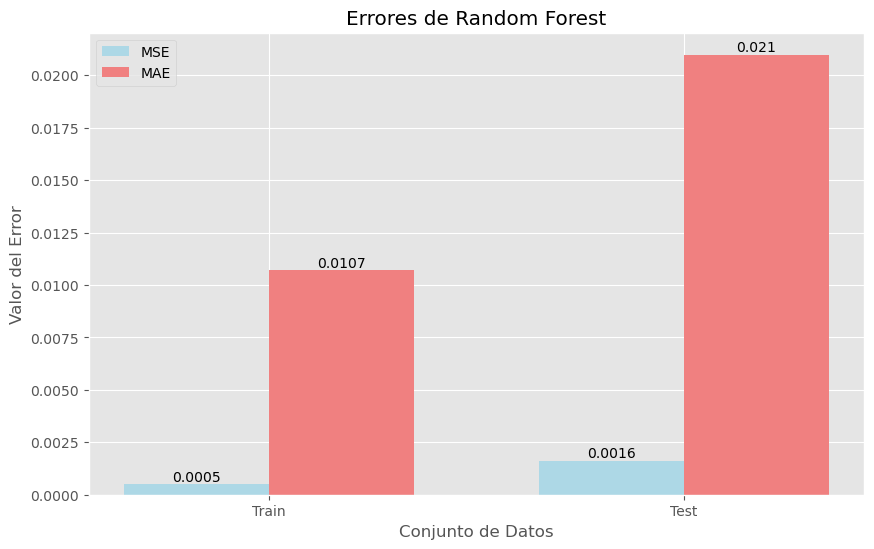

In [85]:
# Valores de los errores
mse_values_rf = [mse_tr_rf, mse_ts_rf]
mae_values_rf = [mae_tr_rf, mae_ts_rf]
error_types_rf = ['Train', 'Test']

# Redondear los valores de los errores
mse_values_rf_rounded = [round(value, 4) for value in mse_values_rf]
mae_values_rf_rounded = [round(value, 4) for value in mae_values_rf]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_types_rf))

# Barra para el MSE
plt.bar(index, mse_values_rf, bar_width, color='lightblue', label='MSE')

# Etiquetas de los valores de MSE
for i, value in enumerate(mse_values_rf_rounded):
    plt.text(i, mse_values_rf[i] , str(value), ha='center', va='bottom', fontsize=10)

# Barra para el MAE
plt.bar(index + bar_width, mae_values_rf, bar_width, color='lightcoral', label='MAE')

# Etiquetas de los valores de MAE
for i, value in enumerate(mae_values_rf_rounded):
    plt.text(i + bar_width, mae_values_rf[i] , str(value), ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.xlabel('Conjunto de Datos')
plt.ylabel('Valor del Error')
plt.title('Errores de Random Forest')
plt.xticks(index + bar_width / 2, error_types_rf)
plt.legend()
plt.show()
